### Business Problem

Scania is one of the leading automobile manufacturing companies with
trucks and Buses being their major frontiers. The trucks manufactured by
them are of supreme quality where each component is designed for
maximum lifetime and minimum time to service or replace. Hence these
trucks hold immense value to the transportation industry as a lot of small
and large scale businesses rely on the trucks to satisfy their necessities.

One of the major systems of the vehicle is the Air pressure system which
produces compressed air which is utilised in driving other systems like the
braking and gear changing systems. So if a sudden failure occurs in any of
the components of the air pressure system, the other systems depending on
it, like the braking system may also get affected which may lead to a
disastrous accident. This would result in heavy losses to the company due to
damages in the transporting cargo, repairs needed to fix the vehicle or even
loss of life of the people inside.

Hence predicting the chances of failures of the components of a vehicle is
highly useful in reducing the operational cost of the company. With proper
understanding of the cause of failure, the company can address the failure
beforehand and thereby reduce the cost of unnecessary checks and could
also reduce the cost of missing a faulty truck which may cause a breakdown.

### ML Formulation to the Business Problem

The case study is posed as a Binary classification Problem where we have to
predict the cause of the failure of a system in a heavy Scania Truck.
The 2 possible causes for the failure are :
    
1. The failure of a component of the Air Pressure System (representing
positive class ) OR
2. The failure of some other component in the vehicle (representing
negative class).

The prediction has to be made by implementing and training an ML model
using the dataset consisting of 60,000 data points, each data point having
170 attributes/features. A test dataset consisting of 16.000 datapoints is also
provided.

The features provided are various sensor data but the names of none of the
features are provided. They are represented using just an alphabetic
identifier and a bin_id but, it is observed that there are several numeric
features and 7 histograms with 10 features in each histogram bins . Other
than the column of features, one more column with the class labels as ‘pos’
and ‘neg’ is also provided.

Business constraints : The aim of the case study is to reduce the total cost,
where total cost = 10*FP + 500*FN , where FP and FN are the number of false positives and number of false negatives resectively. Here the first part is the cost of
unnecessary checks and the second part is the cost of missing a faulty truck.
Second part is given more weightage. As the aim is to minimise the total
cost, the cost of misclassification is very high.
One other constraint is that the latency should be fairly low in detecting the
failure, because long delays in the detection of the failure might be
disastrous.

Evaluation Metric : It is observed that the dataset is highly imbalanced hence
accuracy might not be the best metric and since the cost of misclassification
is high, suitable metrics are F1 score, confusion matrix. However the final
evaluation will be based on the total Cost as described in the business
constraints.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer,SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from  sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [4]:
data_train = pd.read_csv('ida_2016_training_set_update.csv')
data_train.head(5)

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  \
0   neg   76698     na  2130706438    280      0      0      0      0      0   
1   neg   33058     na           0     na      0      0      0      0      0   
2   neg   41040     na         228    100      0      0      0      0      0   
3   neg      12      0          70     66      0     10      0      0      0   
4   neg   60874     na        1368    458      0      0      0      0      0   

   ...   ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008 ee_009 ef_000  \
0  ...  1240520  493384  721044  469792  339156  157956   73224      0      0   
1  ...   421400  178064  293306  245416  133654   81140   97576   1500      0   
2  ...   277378  159812  423992  409564  320746  158022   95128    514      0   
3  ...      240      46      58      44      10       0       0      0      4   
4  ...   622012  229790  405298  347188  286954  311560  433954   1218      0   

  eg_000  
0      0  
1      0  
2      0  
3     32  
4      0  

[5 rows x 171 columns]

In [5]:
data_test = pd.read_csv('ida_2016_test_set_update.csv')
data_test.head(5)

id class  aa_000 ab_000 ac_000 ad_000 ae_000 af_000 ag_000 ag_001  ...  \
0   1    na      60      0     20     12      0      0      0      0  ...   
1   2    na      82      0     68     40      0      0      0      0  ...   
2   3    na   66002      2    212    112      0      0      0      0  ...   
3   4    na   59816     na   1010    936      0      0      0      0  ...   
4   5    na    1814     na    156    140      0      0      0      0  ...   

   ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 ee_009 ef_000  \
0    1098     138     412     654       78      88       0      0      0   
1    1068     276    1620     116       86     462       0      0      0   
2  495076  380368  440134  269556  1315022  153680     516      0      0   
3  540820  243270  483302  485332   431376  210074  281662   3232      0   
4    7646    4144   18466   49782     3176     482      76      0      0   

  eg_000  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 172 columns]

<h4>Number of Data points based on the class label</h4>

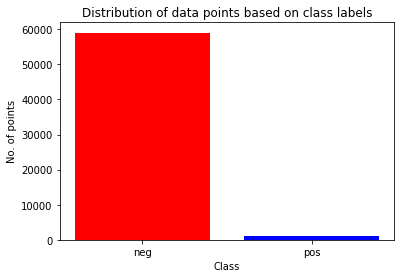

Number of negative labeled points: 59000
Number of positive labeled points: 1000


In [6]:
###  plotting the bargraph of the number of positive and neagtive labeled datapoint  ###

plt.title('Distribution of data points based on class labels')
plt.xlabel('Class')
plt.ylabel('No. of points')
plt.bar(list(data_train['class'].value_counts().keys()),list(np.unique(data_train['class'],return_counts=True)[1])
        ,color=['red','blue'])
plt.show()
print('Number of negative labeled points:',data_train['class'].value_counts()[0])
print('Number of positive labeled points:',data_train['class'].value_counts()[1])


In [7]:
## Now let us replce the 'neg' and 'pos' class labels to 0 and 1 and replace the 'na' values as np.nan 

data_train['class'].replace({'neg':0,'pos':1},inplace=True) 

X_train = data_train.drop(['class'],axis=1)
Y_train = data_train['class'].values
X_test  = data_test.drop(['id','class'],axis=1)

## Now let us replace the missing values represented as'na' to numpy NaN items

X_train = X_train.replace('na',np.nan)
X_test  = X_test.replace('na',np.nan)


In [8]:
X_train_null_percentage = round((X_train.isnull().sum()/(len(X_train)))*100,2)

print('Total number of datapoints:',60000*170)
print('Total number of missing datapoints:',X_train.isnull().sum().sum())
print('So {} % of total datapoints are missing'.format(X_train.isnull().sum().sum()*100/(60000*170)))

Total number of datapoints: 10200000
Total number of missing datapoints: 850015
So 8.333480392156863 % of total datapoints are missing


- As 8.3 % of total datapoints is not a number that we can just ignore and remove. Hence we need proper imputation strategies to fill the missing values


- First let us find out the number of missing values each feature column has.

<h4>Percentage of Missing values per feature</h4>

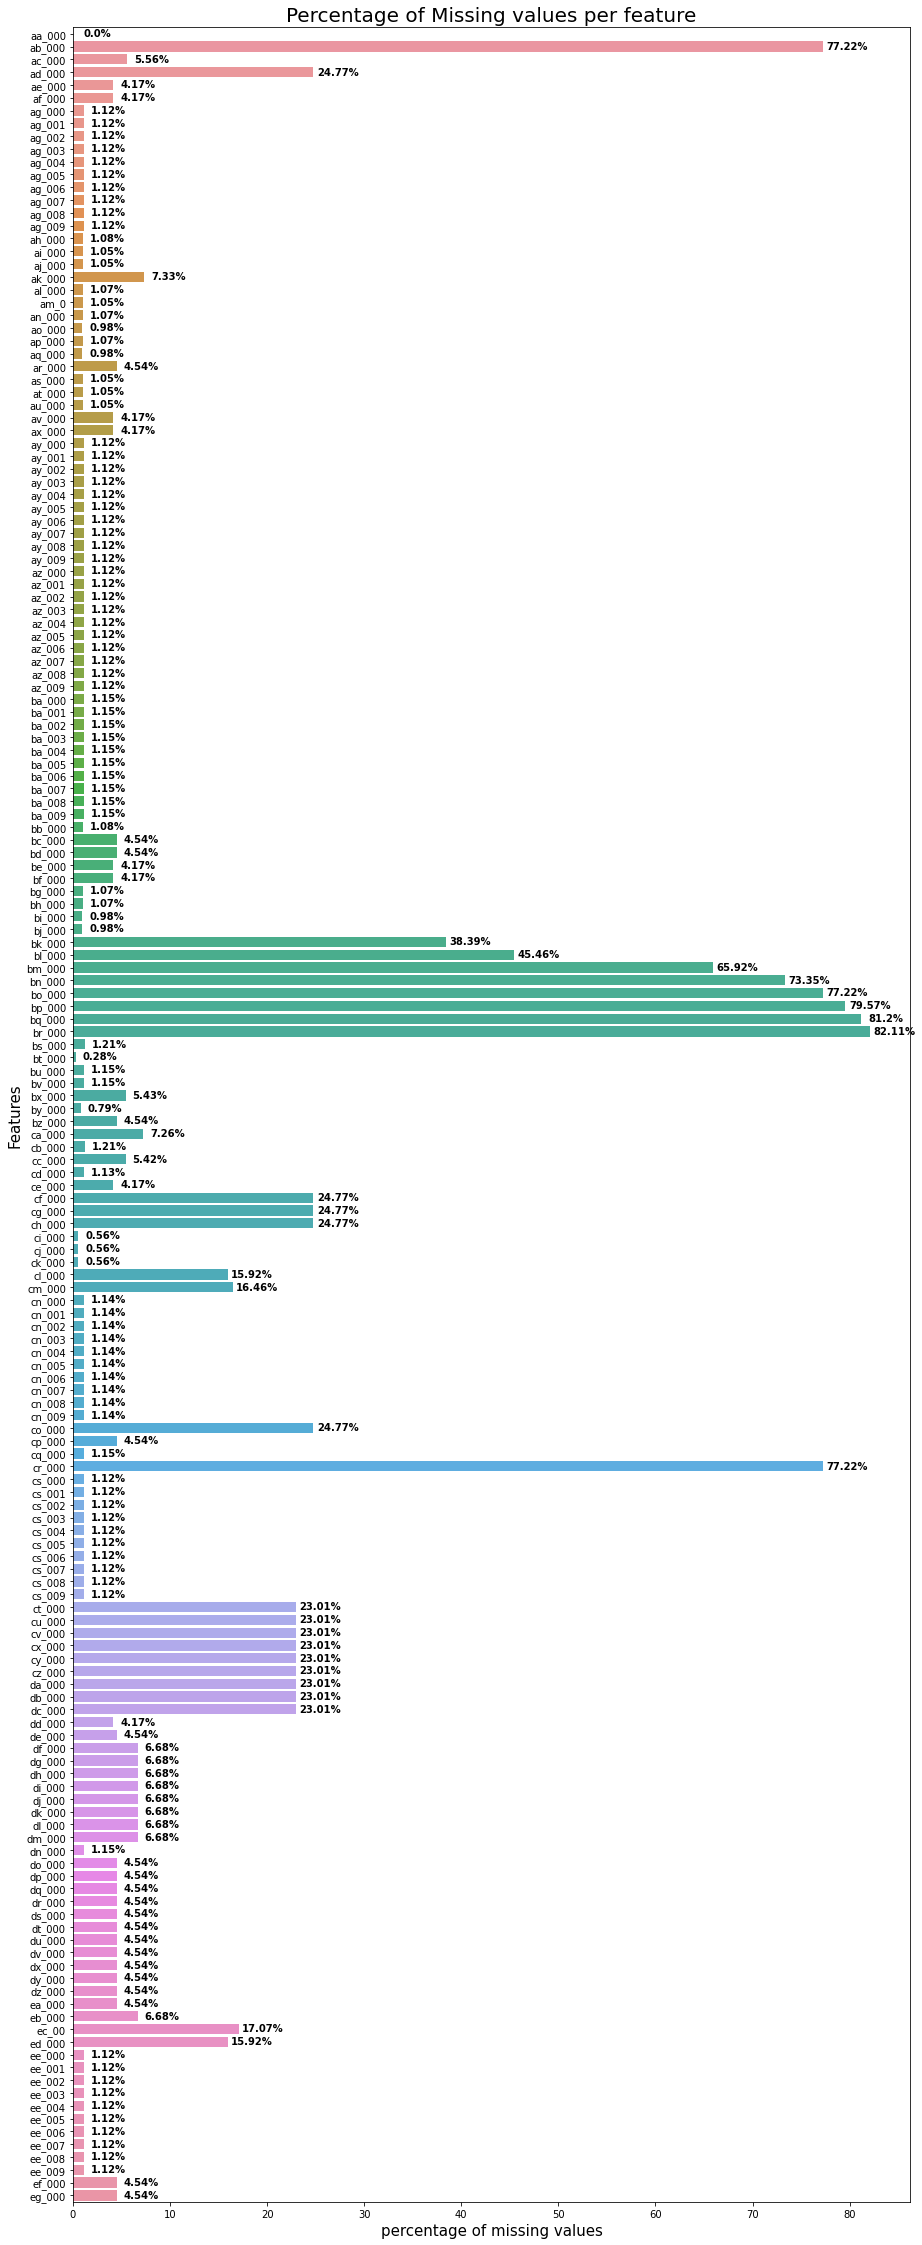

In [9]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(40)
bar = sns.barplot(y = X_train.columns,x = X_train_null_percentage)

i=0
for i,j in enumerate(X_train_null_percentage):
    plt.text(j+2.5,i+0.2,str(X_train_null_percentage[i])+'%',ha='center',weight='bold')
plt.title('Percentage of Missing values per feature',fontsize=20)
plt.xlabel('percentage of missing values',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.show()

- From the above plot we can see that some of the features have a missing value percentage of more than 70%, while majority of the features has a missing value percentage of less than 25%. 


- As we observe the plot, we can group the features into 4 groups with missing values percentage in the range of 0 to 5%, 5-25%, 25-80% and 70% and above

In [10]:
group_1 = []
group_2 = []
group_3 = []
group_4 = []
for i in X_train_null_percentage:
    if i<=5:
        group_1.append(i)
    elif i>5 and i<=25:
        group_2.append(i)
    elif i>25 and i<=80:
        group_3.append(i)
    else:
        group_4.append(i)

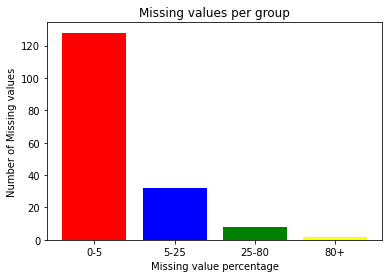

In [11]:
plt.bar(['0-5','5-25','25-80','80+'],[len(group_1),len(group_2),len(group_3),len(group_4)],color=['red','blue','green','yellow'])
plt.xlabel('Missing value percentage')
plt.ylabel('Number of Missing values')
plt.title('Missing values per group')
plt.show()

- From the plot We can see that majority of the features has a missing value percentage between 0 and 5. The number of features with missing value percentage greater than 80% are small in number and also imputing those features would not be so optimal, hence we can remove those features.


- For the other features we will perform imputations strategies like KNN or MICE imputation based on the type of missingness of data.

#### Removing columns with greater than 80% NaN values

In [12]:
print('shape of X_train before removing any columns:',X_train.shape)
eighty_percent_val = int((80*60000)/100)
for i in X_train:
    if X_train[i].isnull().values.any():
        if (X_train[i].astype('str').value_counts()['nan'] )>= eighty_percent_val:
            print('Removing column',i)
            del X_train[i]
            del X_test[i]
print('shape of X_train after removing unwanted columns:',X_train.shape)  

shape of X_train before removing any columns: (60000, 170)
Removing column bq_000
Removing column br_000
shape of X_train after removing unwanted columns: (60000, 168)


# MISSING VALUE IMPUTATION

The Missing values in the dataset has not been described as Missing at Random (MAR) or Missing Completely at Random (MCAR). So based on the understanding from the research papers we will do KNN based imputation which assumes the data is Missing Completely at Random, and the multiple imputation strategy called MICE which assumes the data is Missing at Random. The imputed dataset obtained after both these imputations will be compared using a technique to determine which imputation to use. 

The technique is that, already known values from the dataset are made as NaN values and these NaN values are filled using KNN and mice imputation and the better strategy is selected as that one with less mean squared error between the actual and imputed values.

Before performing the imputations, we will first normalise the data as MICE uses linear regression in learning the missing values and KNN imputation uses distance measure to finds the nearest neighbour, So if the data is not normalised the presence of outliers might result in faulty imputations.

In [11]:
mm = MinMaxScaler()
mm.fit(X_train)

mm_train = mm.fit_transform(X_train)
X_train_norm = pd.DataFrame(mm_train,columns=X_train.columns)

mm_test = mm.fit_transform(X_test)
X_test_norm  = pd.DataFrame(mm_test,columns=X_test.columns)

In [ ]:
pickle.dump(mm, open('imputations_&_FE//mm_normalizer.pkl', 'wb'))

#mm = pickle.load(open('imputations_&_FE//mm_normalizer.pkl', 'rb'))

#### MICE Imputation

For MICE imputation we are using the iterativeimuter from scikit learn.

In [75]:
imputer_mice = IterativeImputer(estimator=BayesianRidge(),verbose=2,max_iter=15)
imputer_mice.fit(X_train_norm)

X_train_mice_imputed = pd.DataFrame(imputer_mice.transform(X_train_norm),columns=X_train_norm.columns)
X_test_mice_imputed  = pd.DataFrame(imputer_mice.transform(X_test_norm),columns=X_test_norm.columns)

[IterativeImputer] Completing matrix with shape (60000, 168)
[IterativeImputer] Ending imputation round 1/15, elapsed time 342.49
[IterativeImputer] Change: 19.018301754596955, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/15, elapsed time 680.97
[IterativeImputer] Change: 15.033672565791692, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/15, elapsed time 1022.08
[IterativeImputer] Change: 22.364966239564556, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/15, elapsed time 1360.04
[IterativeImputer] Change: 41.83609250242398, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 5/15, elapsed time 1709.53
[IterativeImputer] Change: 45.81969398732224, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 6/15, elapsed time 2048.44
[IterativeImputer] Change: 50.26754659187587, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 7/15, elapsed time 2392.66
[IterativeImputer] Cha

In [ ]:
pickle.dump(imputer_mice, open('imputations_&_FE//imputer_mice.pkl', 'wb'))

#### KNN Imputation

For KNN imputation also we will use the KNNImputer from scikit learn adn we will use a nearest negihtbours as 5.

In [76]:
imputer_knn = KNNImputer(n_neighbors=5,weights='distance')
imputer_knn.fit(X_train_norm)

X_train_knn_imputed = pd.DataFrame(imputer_knn.transform(X_train_norm),columns=X_train_norm.columns)
X_test_knn_imputed  = pd.DataFrame(imputer_knn.transform(X_test_norm),columns=X_test_norm.columns)

In [ ]:
pickle.dump(imputer_knn, open('imputations_&_FE//imputer_knn.pkl', 'wb'))

##### Comparing the performance of Mice and KNN imputation

In [86]:
## https://medium.com/analytics-vidhya/aps-component-failure-classification-in-scania-trucks-a971fcf71846

def imputation_check(data_train,imputer):
    
    '''   
           This function gives the performance of the imputation strategy. A feature is selected from the data_train 
           at random and the first 50 rows in which the feature has known values are selected initially. Then the considered 
           feature column is set to missing (NaN). The the given imputation strategy will be performed and it will fill the 
           missing values of the feature column. Then the known and imputed values of the feature column are saved in an array.
           This process is carried out to 10 feature columns of data_train and finally the mean square error between the known 
           and imputed values is returned.
           parameters:
           data_train - input dataset to be imputed
           imputer    -  name of the imputation strategy as string
    '''
    
    known_val     = np.array([])
    predicted_val = np.array([])
    
    columns = ['ac_000','ag_001','az_003','ab_000','df_000','bk_000','dy_000','bl_000','ad_000','cf_000']
    
    for column in columns:
        
        rows = np.argwhere(~np.isnan(data_train[column].astype(np.float).values)).ravel()[:50]
        X_rows = data_train.iloc[rows]
        
        X_rows[column] = np.nan
        
        if imputer == 'mice':
            X_imputed = pd.DataFrame(imputer_mice.transform(X_rows),columns=data_train.columns)
        
        elif imputer == 'knn':
            X_imputed = pd.DataFrame(imputer_knn.transform(X_rows),columns=data_train.columns)
        
        known_val = np.append(known_val,data_train.iloc[rows][column])
        predicted_val= np.append(predicted_val,X_imputed[column])
        
    return mean_squared_error(known_val,predicted_val)

In [87]:
mse_mice= imputation_check(X_train_norm,'mice')
mse_knn = imputation_check(X_train_norm,'knn')

[IterativeImputer] Completing matrix with shape (50, 168)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.06

[IterativeImputer] Ending imputation round 14/15, elapsed time 0.12
[IterativeImputer] Ending imputation round 15/15, elapsed time 0.12
[IterativeImputer] Completing matrix with shape (50, 168)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.06

In [88]:
print('Mean squared error for KNN imputed dataset:',mse_knn)
print('Mean squared error for MICE imputed dataset:',mse_mice)

Mean squared error for KNN imputed dataset: 1.5644626860401076e-14
Mean squared error for MICE imputed dataset: 0.03129858158387523


From the above results it is clear that the KNN imputed dataset gave the lowest Mean squared error than the MICE imputed dataset. Hence we can continue with the further EDA using the KNN imputed dataset

In [370]:
X_train_knn_imputed

aa_000    ab_000        ac_000        ad_000  ae_000    af_000  \
0      0.027925  0.000000  9.999998e-01  3.261769e-08     0.0  0.000000   
1      0.012036  0.000000  0.000000e+00  3.484628e-08     0.0  0.000000   
2      0.014942  0.000000  1.070067e-07  1.164918e-08     0.0  0.000000   
3      0.000004  0.000000  3.285295e-08  7.688457e-09     0.0  0.000498   
4      0.022164  0.000000  6.420405e-07  5.335323e-08     0.0  0.000000   
...         ...       ...           ...           ...     ...       ...   
59995  0.055707  0.001933  3.116337e-07  2.166747e-08     0.0  0.000000   
59996  0.000832  0.000000  9.999999e-01  2.609416e-08     0.0  0.000000   
59997  0.000041  0.000000  9.999998e-01  2.096852e-09     0.0  0.000000   
59998  0.029234  0.000000  9.999998e-01  5.754693e-08     0.0  0.000000   
59999  0.014644  0.000000  3.275908e-07  7.315683e-08     0.0  0.000000   

       ag_000  ag_001  ag_002    ag_003  ...    ee_002    ee_003  \
0         0.0     0.0     0.0  0.000000  ...  0.015918  0.013067   
1         0.0     0.0     0.0  0.000000  ...  0.005407  0.004716   
2         0.0     0.0     0.0  0.000000  ...  0.003559  0.004232   
3         0.0     0.0     0.0  0.000005  ...  0.000003  0.000001   
4         0.0     0.0     0.0  0.000000  ...  0.007981  0.006086   
...       ...     ...     ...       ...  ...       ...       ...   
59995     0.0     0.0     0.0  0.000040  ...  0.012812  0.015013   
59996     0.0     0.0     0.0  0.000000  ...  0.000136  0.000179   
59997     0.0     0.0     0.0  0.000000  ...  0.000010  0.000010   
59998     0.0     0.0     0.0  0.000000  ...  0.008974  0.005897   
59999     0.0     0.0     0.0  0.000000  ...  0.005647  0.004852   

             ee_004        ee_005        ee_006    ee_007    ee_008    ee_009  \
0      7.421784e-03  8.179508e-03  1.073013e-02  0.001321  0.003800  0.000000   
1      3.019031e-03  4.272917e-03  4.228511e-03  0.000679  0.005064  0.000394   
2      4.364196e-03  7.130884e-03  1.014768e-02  0.001321  0.004937  0.000135   
3      5.970003e-07  7.660803e-07  3.163775e-07  0.000000  0.000000  0.000000   
4      4.171776e-03  6.044861e-03  9.078578e-03  0.002605  0.022523  0.000320   
...             ...           ...           ...       ...       ...       ...   
59995  1.328221e-02  2.121074e-02  3.226316e-02  0.006002  0.046641  0.007503   
59996  2.174522e-04  1.191324e-03  4.302733e-06  0.000000  0.000000  0.000000   
59997  4.652485e-06  2.507172e-06  4.619111e-06  0.000022  0.000000  0.000000   
59998  3.575600e-03  3.930061e-03  6.151643e-03  0.001380  0.041639  0.101946   
59999  3.546449e-03  4.423556e-03  7.123175e-03  0.001324  0.008843  0.000041   

         ef_000    eg_000  
0      0.000000  0.000000  
1      0.000000  0.000000  
2      0.000000  0.000000  
3      0.008299  0.027923  
4      0.000000  0.000000  
...         ...       ...  
59995  0.000000  0.000000  
59996  0.000000  0.000000  
59997  0.000000  0.000000  
59998  0.000000  0.000000  
59999  0.000000  0.000000  

[60000 rows x 168 columns]

##### Separating features into Histogram and Numerical features

In [94]:
def separating_features(data):
    
    '''
          This function separates the given dataset into 2 subsets. One subset dataframe with the numerical features and the 
          other with the histogram features. The datasets are distinguished using an alphabetic identifier with 2 alphabets and 
          3-integer bin_id separated by an undersdcore (eg:'aa_000'). The alphabetic identifier of the histogram feature is 
          found out by checking if the bin_id is greater than 000. Once the alphabetc identifier of histogram features is found 
          the numeric and histogram features are separated by iterating through the dataset column names.
          parameters:
          data - input data to be separated.         
    '''
    feature_prefix = []
    for feature in data.columns:
        feature_prefix.append(feature.split('_')[0])
    
    feature_prefix_dict={}
    for i in feature_prefix:
         feature_prefix_dict[i]=feature_prefix.count(i)
        
    hist_features_prefix = [key for key,val in feature_prefix_dict.items() if val>1]      
    
    hist_features      = []
    numerical_features = []

    for i in data.columns:
        if i.split('_')[0] in hist_features_prefix:
            hist_features.append(i)
        else:
            numerical_features.append(i)  
            
    return data[hist_features],data[numerical_features]        

In [95]:
## splitting train and test dataset features to histogram and numerical features

X_train_hist,X_train_num = separating_features(X_train_knn_imputed)
X_test_hist,X_test_num   = separating_features(X_test_knn_imputed)

print('shape of X_train_hist:',X_train_hist.shape)
print('shape of X_train_num:',X_train_num.shape)
print('shape of X_test_hist:',X_test_hist.shape)
print('shape of X_test_num:',X_test_num.shape)

shape of X_train_hist: (60000, 70)
shape of X_train_num: (60000, 98)
shape of X_test_hist: (16000, 70)
shape of X_test_num: (16000, 98)


In [13]:
X_train_hist = pd.read_csv('saves//X_train_hist.csv',index_col=0)
X_test_hist = pd.read_csv('saves//X_test_hist.csv',index_col=0)
X_train_num = pd.read_csv('saves//X_train_num.csv',index_col=0)
X_test_num = pd.read_csv('saves//X_test_num.csv',index_col=0)


Now since the dataset does not have missing values we can perfromn the exploratory data analysis.


 As there is a total of 168 features, we will be doing EDA on the top 15 histogram and numerical features. We will find the top features using a random forest classifier.

# Exploratory Data Analysis on Top 15 Histogram Features

In [74]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_hist, Y_train)

importance_hist = clf.feature_importances_
indices_hist = np.argsort(importance_hist)[::-1]

top_15 = pd.DataFrame({'Features':list(X_train_hist.columns[indices_hist][:15]),'Importance':list(importance_hist[indices_hist][:15])})
top_15

Features  Importance
0    ag_002    0.059883
1    ee_005    0.056720
2    ag_003    0.037340
3    ee_000    0.032988
4    ag_001    0.032163
5    cs_002    0.028283
6    ba_000    0.027513
7    ay_006    0.024384
8    cn_000    0.023606
9    az_000    0.022976
10   ba_003    0.022295
11   cn_001    0.021893
12   ay_005    0.021672
13   ba_004    0.020304
14   cs_004    0.019269

In [158]:
X_hist_top_15 = X_train_hist[top_15['Features']]
X_hist_top_15['class'] = Y_train
X_hist_top_15.head(3)

ag_002    ee_005  ag_003    ee_000  ag_001    cs_002    ba_000    ay_006  \
0     0.0  0.008180     0.0  0.012881     0.0  0.005815  0.010000  0.033205   
1     0.0  0.004273     0.0  0.008862     0.0  0.003577  0.005920  0.006052   
2     0.0  0.007131     0.0  0.003494     0.0  0.001223  0.003395  0.006817   

   cn_000    az_000    ba_003  cn_001    ay_005    ba_004    cs_004  class  
0     0.0  0.000531  0.007777     0.0  0.003754  0.012332  0.005728      0  
1     0.0  0.000725  0.004178     0.0  0.000572  0.005457  0.003646      0  
2     0.0  0.000160  0.006902     0.0  0.000000  0.007536  0.001340      0

Above given dataframe contains the top 10 histogram features with the column of class label also

<h2>Univariate Analysis</h2>

PDF, CDF and Box Plot  of the top 15 histogram features

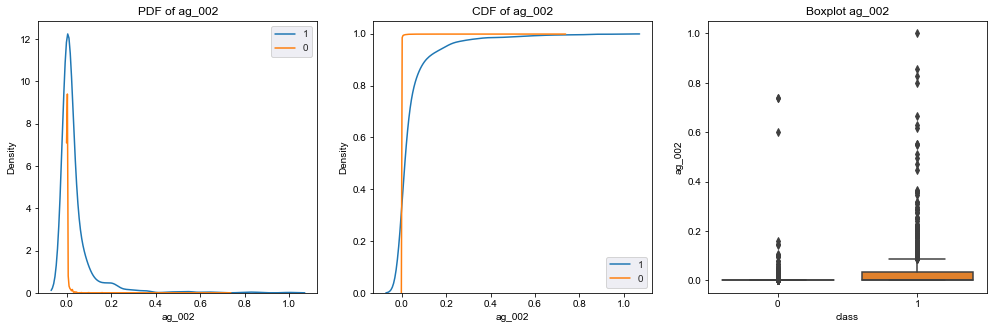

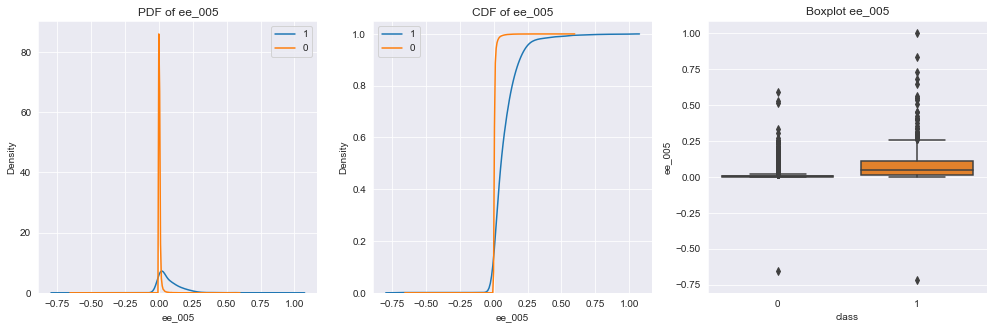

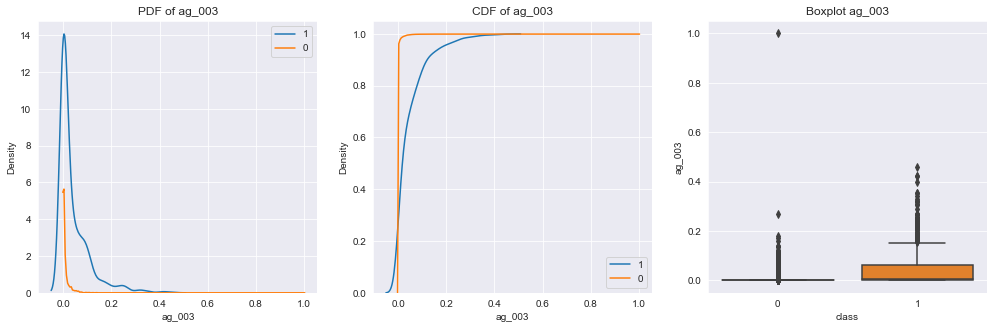

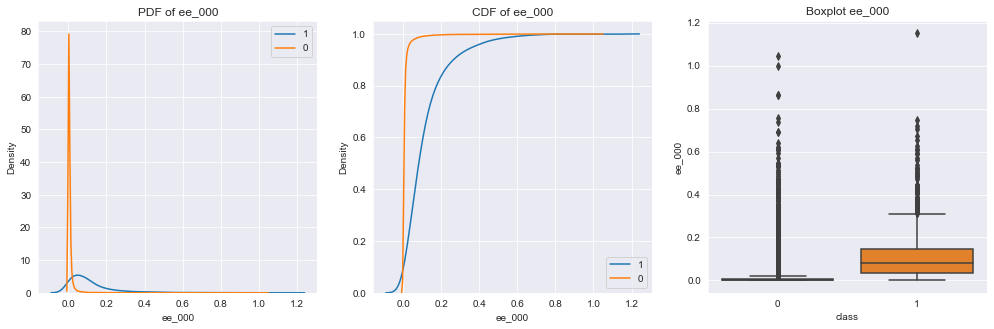

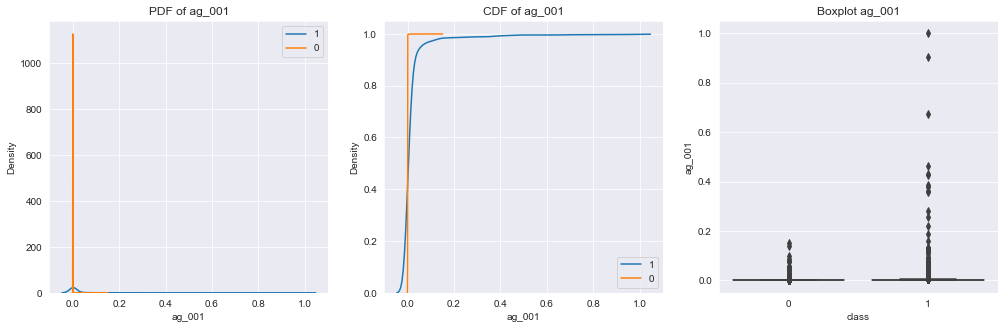

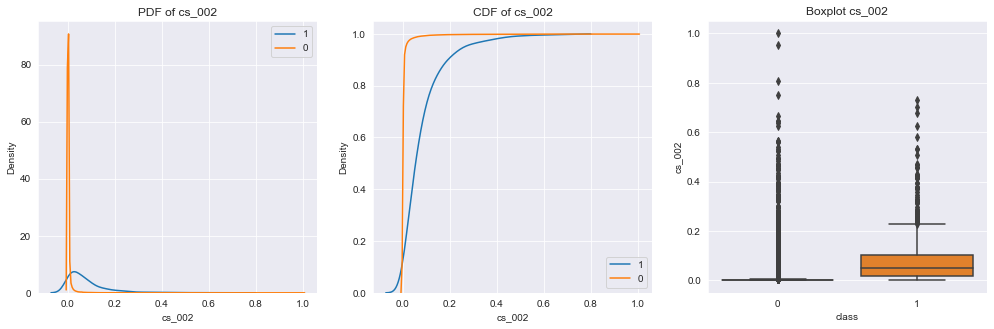

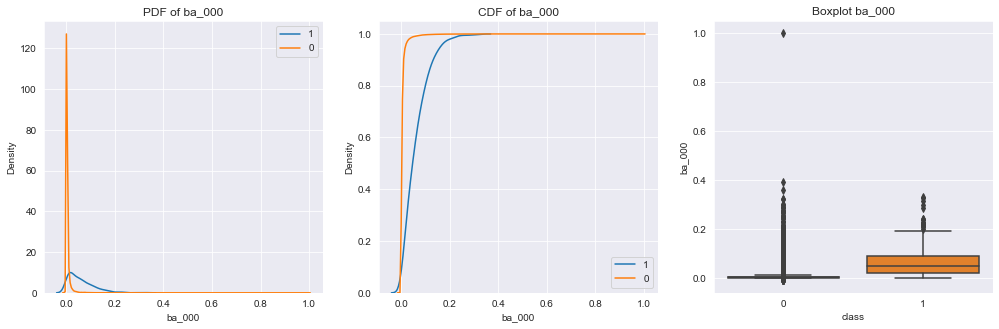

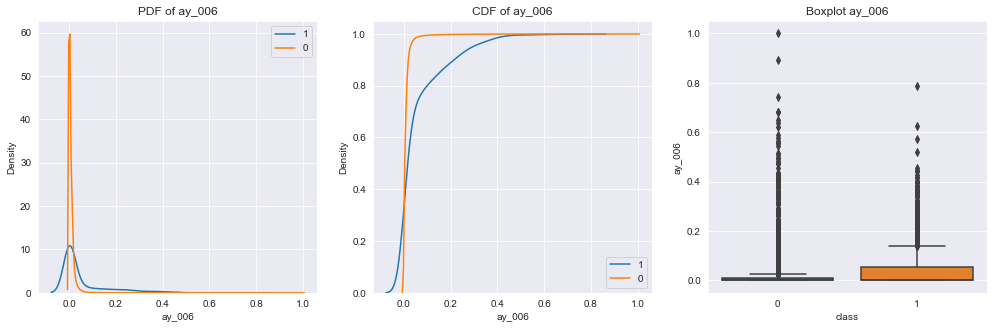

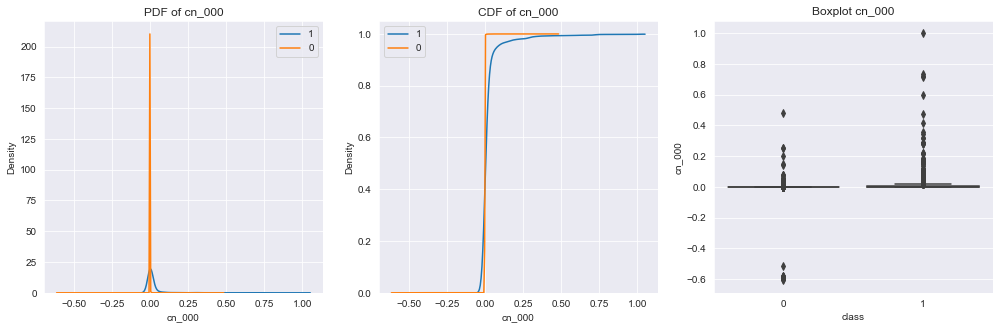

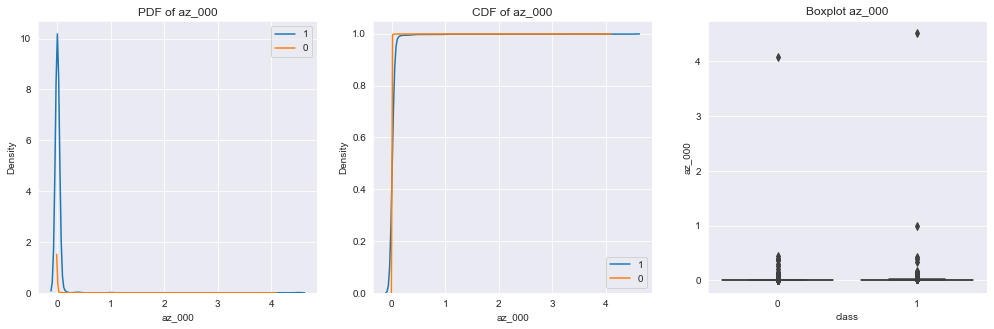

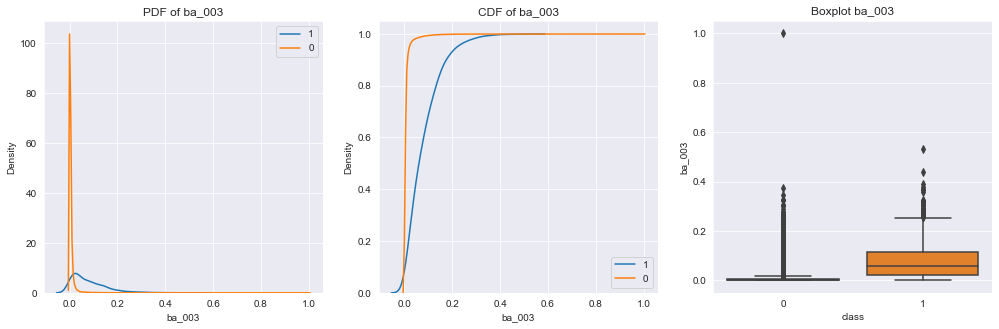

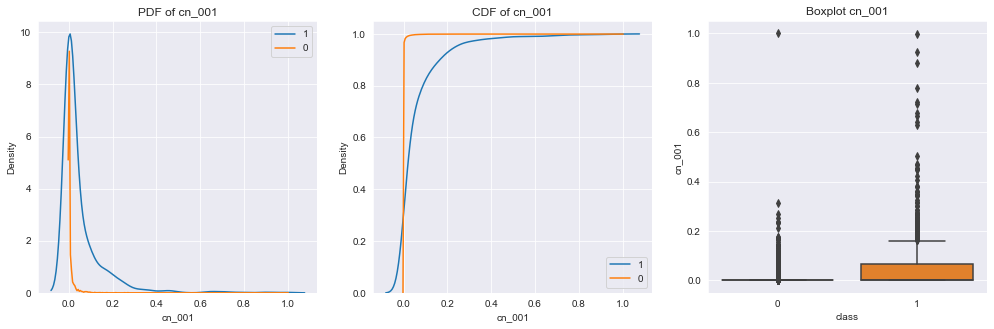

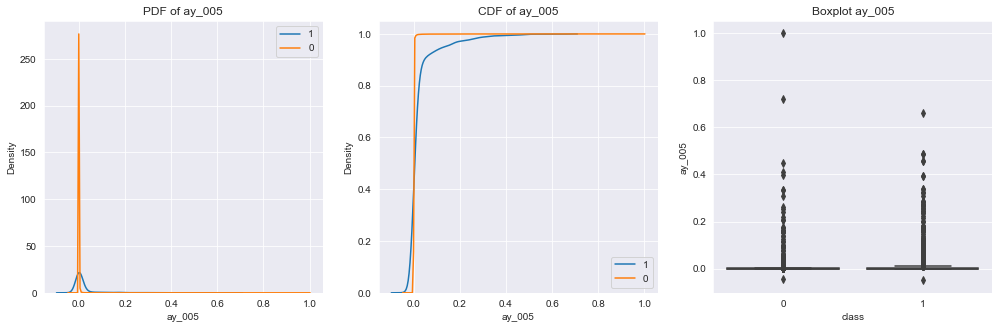

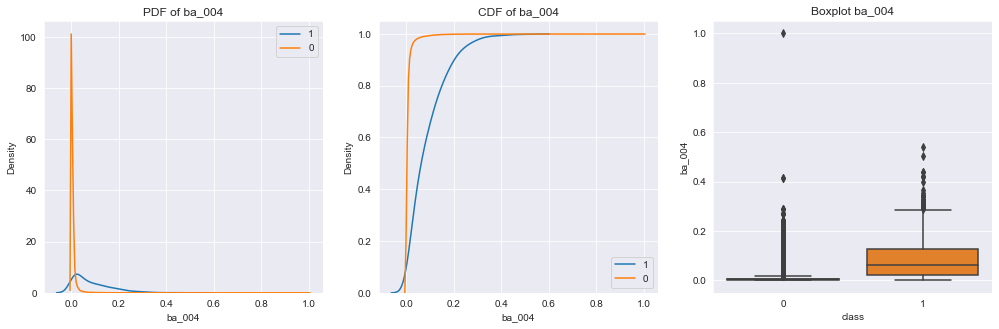

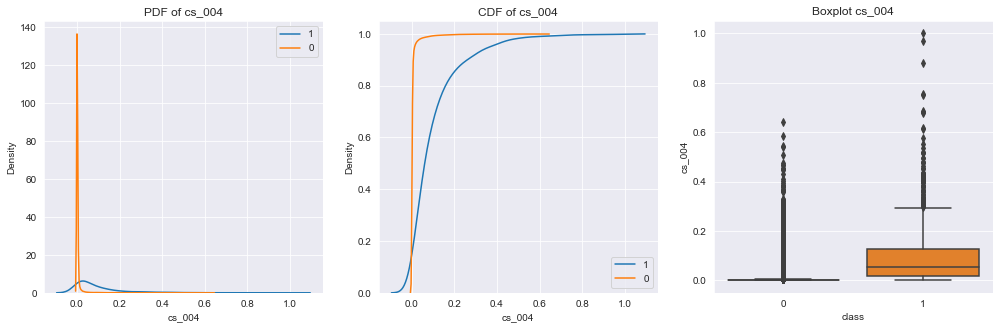

In [76]:
def univariate_plots(data):
    for i in data.drop(['class'],axis=1):
        fig,ax = plt.subplots(1,3,figsize=(17,5))
        sns.set_style('darkgrid')
        
        sns.kdeplot(data[data['class']==1][i],ax=ax[0],label=1)
        sns.kdeplot(data[data['class']==0][i],ax=ax[0],label=0)
        sns.kdeplot(data[data['class']==1][i],cumulative=True,ax=ax[1],label=1)
        sns.kdeplot(data[data['class']==0][i],cumulative=True,ax=ax[1],label=0)
        sns.boxplot(x='class',y=i,data=data,ax=ax[2])
        
        ax[0].set_title('PDF of '+i)
        ax[1].set_title('CDF of '+i)
        ax[2].set_title('Boxplot '+i)
        ax[0].legend()
        ax[1].legend()
        plt.show()
        
univariate_plots(X_hist_top_15)

- Even though we know that the positive labeled(label=1) points are very much less than the negative labeled (label=0) points, from the PDFs and CDFs it can be seen that the positive labeled points are much more spread than the negatively labelled points. As we have already normalised the dataset, the values fall between 0 and 1.


- From the PDF we can see that majoity of the negative labelled points are having a value of 0 or very close to 0 indicated by the high peak of the orange line distribution at 0.00 value in the PDF curve for almost all the feature plots. This can also be identified by the almost vertical increase from 0.0 to 1.0 in all the CDF curves for the negative labeled points signifying that more than close to 98% of values have a value of 0.0.


- For features ba_004, ba_003, ee_000, cs_002, ba_000, cs_004 the box plots show good separation between the interquantile ranges of positive and negative class points.

<h2>Multivariate Analysis</h2>

###### Checking correlation 

- We will be initially checking the correlation of the top 15 features with the class label. Then we will plot the correlation matrix of the all the features.


- We will use the default correlation method of the pandas pairwise correlation API which is Pearson's correlation coefficient.


- Pearson's correlation coefficient is the ratio of Covariance of the feature pair to the product of standard deviations of the 2 features.


- If a feature has high correlation with the class label then that feature could be useful for the classification. But when a feature is highly correlated with another feature, then it means both the features are related in some ways and hence we could remove one of the feature.

In [80]:
def corr_with_Y(data):
    plt.figure(figsize=(10,4))
    sns.barplot(x=data.corr()['class'].index[:-1],y=data.corr()['class'][:-1])
    plt.xlabel('Features')
    plt.ylabel('Pearson correlation coeff')
    plt.title('Correlation of features with class label')
    plt.xticks(rotation=45)
    plt.show()
def correlation_matrix(data):
    plt.figure(figsize=(15,8))
    sns.heatmap(data.corr(),annot=True)
    plt.title("Correlation Matrix")
    plt.show()


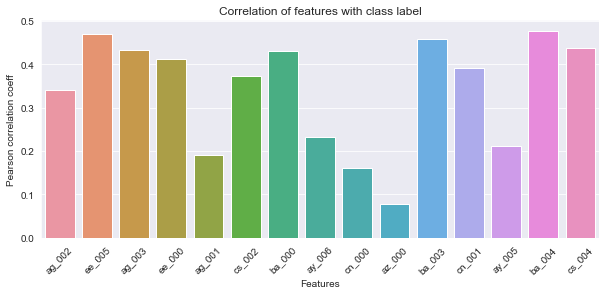

In [81]:
corr_with_Y(X_hist_top_15)    

- Features ag_001,cn_000,ay_005 and az_000 have significantly lower correlation of less than 0.25 with the class label than the rest of the features.


- We can see that the spread in the PDFs of the positive class of these 4 featurs are low compared to the rest of the features. Also the positive and negative class CDFs of these 4 features are close to overlapping each other which indicates that these 4 features are less related of the class label.

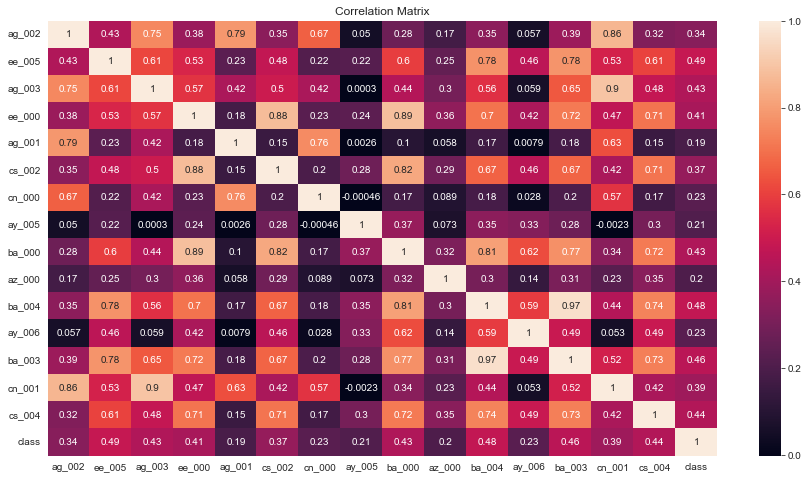

In [275]:
correlation_matrix(X_hist_top_15)

- From the correlation matrix we will select some features with low correlation and some features with high correlation and plot the scatter plots of them. Features having low correlation would probably be able to separate the positive and negative labeled points more correctly and those features having high correlation would be difficult to separate the positive and negative labeled points.


- So we can plot the scatter plots of az_000-ag_001, ay_005-cn_000, cn_001-ay_006, ba_000-ag_001, cn_001-ag_003, ba_003-ba_004, ee_000-ba_000, cs_002-ee_000.


##### Scatter plots

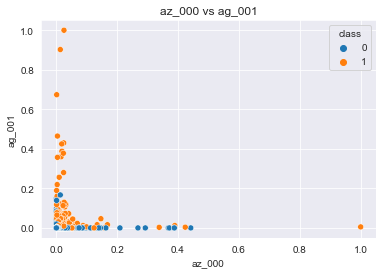

************************************************************


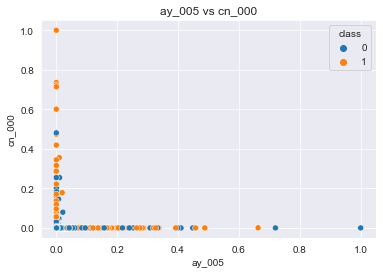

************************************************************


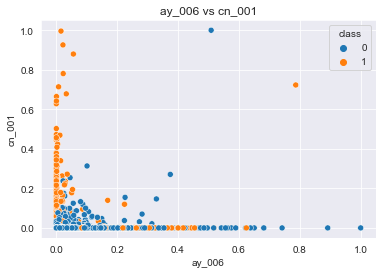

************************************************************


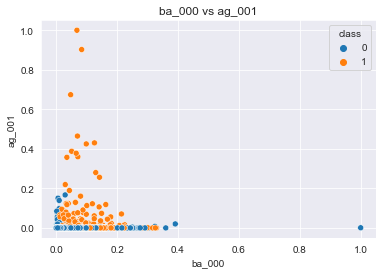

************************************************************


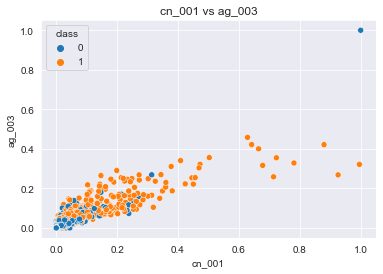

************************************************************


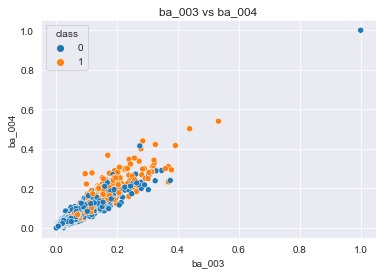

************************************************************


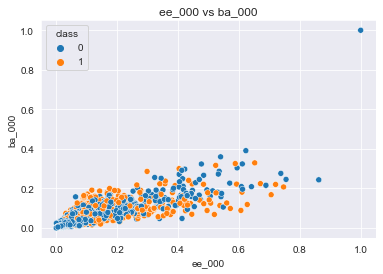

************************************************************


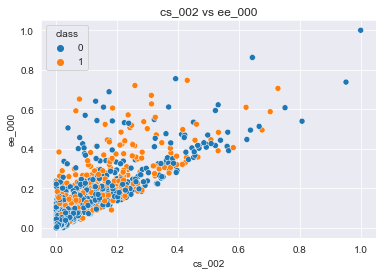

************************************************************


In [276]:
def scatterplot(x,y,data):
    
    sns.scatterplot(x,y,hue='class',data=data)
    plt.title(x+' vs '+y)
    plt.show()
    print('*'*60)
       
scatterplot('az_000','ag_001',X_hist_top_15) 
scatterplot('ay_005','cn_000',X_hist_top_15)  
scatterplot('ay_006','cn_001',X_hist_top_15)  
scatterplot('ba_000','ag_001',X_hist_top_15) 

scatterplot('cn_001','ag_003',X_hist_top_15) 
scatterplot('ba_003','ba_004',X_hist_top_15) 
scatterplot('ee_000','ba_000',X_hist_top_15) 
scatterplot('cs_002','ee_000',X_hist_top_15) 



- For the first 4 plots i.e the features with low correlation ,the datapoints that have a siginificantly higher value are almost all positive labeleled points. Hence we can separate the positive and negative labeled points reasonably well using these features.


- The top 4 scatter plot is almost 'L' shaped. This means that when one the value for one feature increase the other feature value remains at 0 and vice versa. i.e there is very low correlation between the two features and hence these features are useful in the classification.


- While for the bottom 4 plots i.e the features with high correlation, the positive and negative datapoints are mixed up and are difficult to separate. Hence the features used in the bottom 4 plots would be less useful than the features in the top 4 scatter plots.

<h4>Pair Plots</h4> 

We will plot the pair plots for 7 features from the top 15 histogram features.

In [182]:
X_hist_pp = X_hist_top_15[['cs_002','ba_004','ag_003','cn_001','ee_000','cs_004','az_000','class']]

<Figure size 720x480 with 0 Axes>

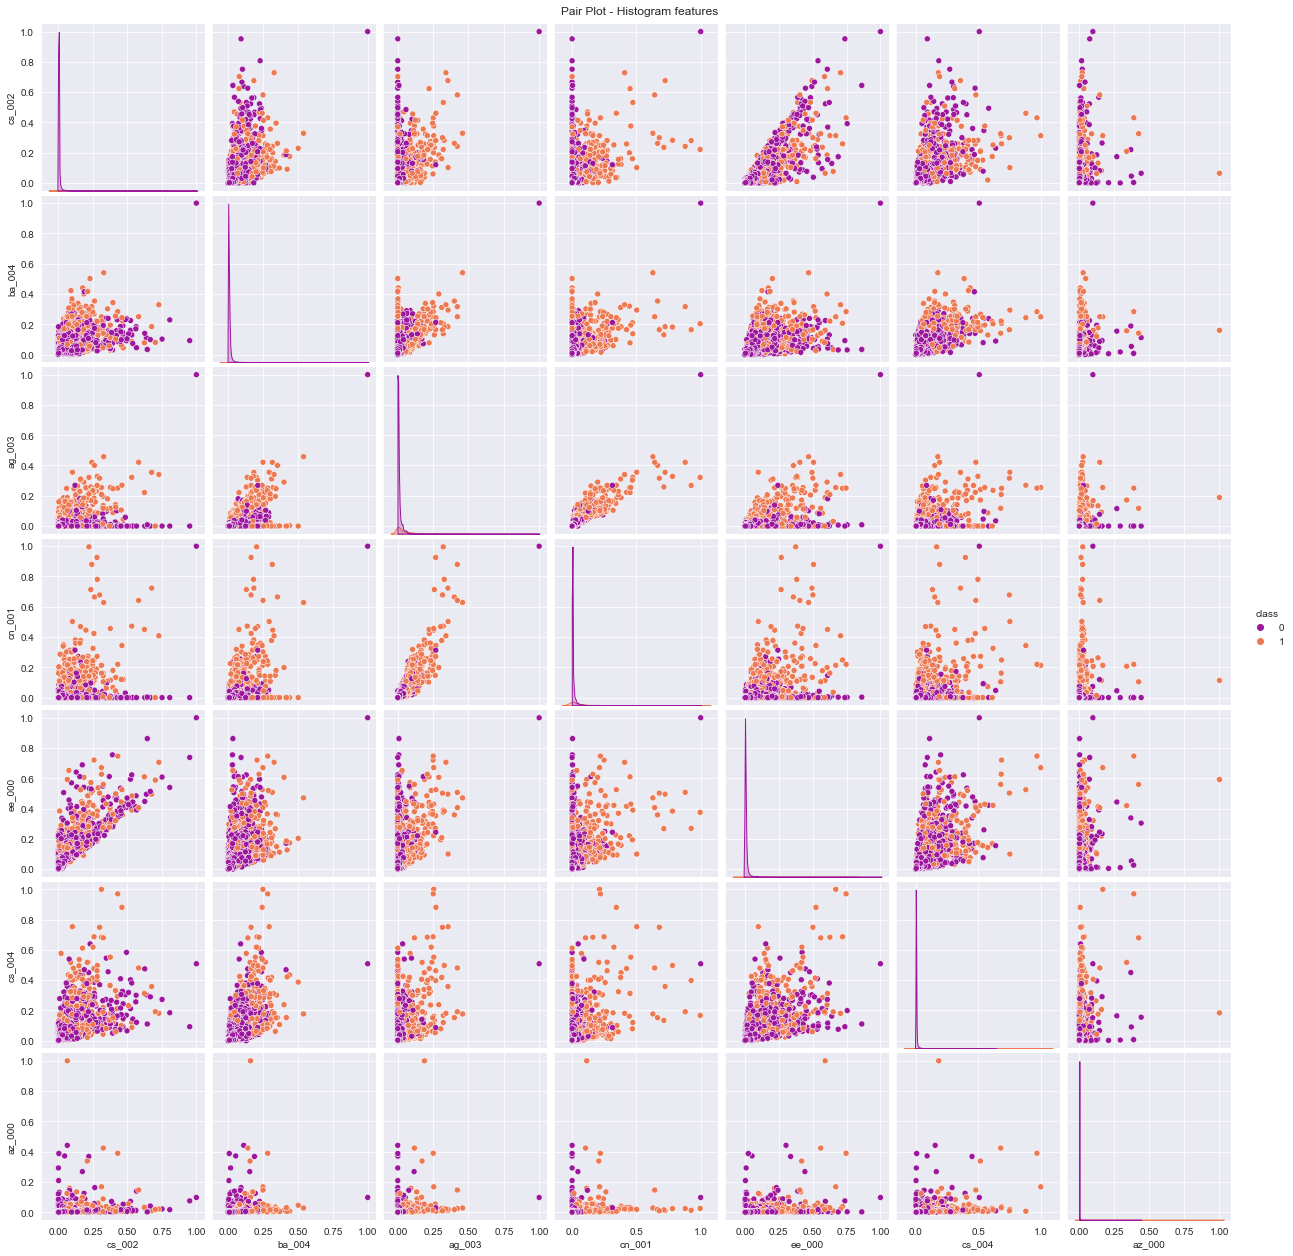

In [209]:
plt.figure(dpi = 120)
g=sns.pairplot(X_hist_pp,hue='class',palette = 'plasma')
g.fig.suptitle('Pair Plot - Histogram features',fontsize='large',y=1.00)
plt.show()

- Plots between cn_001 and all the other features show good separation between the positive and negative labeled datapoints.


- Plot between ag_003 and cs_002 also show good separation while rest of the plots show significant overlap, hence no clear conclusions can be drawn from them.

<h4>Applying T-SNE for Data Visualization</h4>

- We will initially plot the T-SNE plot for the entire histogram features using TSNE from sklearn.manifold module and obtain a 2 dimensional visualization of the 70 dimension(features) dataset.


- Then, as we have selected the top 15 histogram features for doing the univariate analysis and scatter plots, we will plot the TSNE for these top 15 histogram features only and check how useful would be the top 15 features.



In [125]:
## T-SNE on all histigram features ##

tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1)
transformed_hist = tsne.fit_transform(X_train_hist)

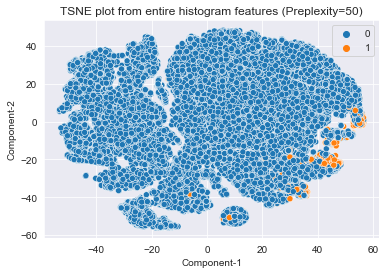

In [122]:
sns.scatterplot(transformed_hist[:,0], transformed_hist[:,1], hue=Y_train)
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('TSNE plot from entire histogram features (Preplexity=50)')
plt.show()

- From the t-SNE plot from all the histogram features, we can see that the positve labeled orange points are forming some clusters towards the right side of the plot, but due to the excessive number of blue minority labeled points the presence of the some positive labeled points are not identified clearly.


- Now let us perfrom the t-SNE on top 15 numerical features.

In [ ]:
## T-SNE on top 15 histigram features ##

tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1)
transformed_hist = tsne.fit_transform(X_hist_top_15)

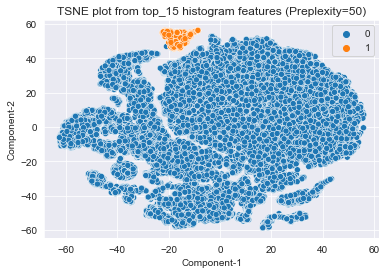

In [123]:
sns.scatterplot(transformed_15_hist[:,0], transformed_15_hist[:,1], hue=Y_train)
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('TSNE plot from top_15 histogram features (Preplexity=50)')
plt.show()

- From the TSNE plot from the top 15 histogram features, we can clearly see a clear separation for the majority and minority labeled poinys. All the minority class points which is the positive labeled points are arranged in a small, well separated cluster while the majority negative labeled points are arranged as the bigger cluster.


- This visualization helps us understand that the selelcted 15 features are good at classifying the datapoints.

# Exploratory Data Analysis on Top 15 Numerical Features

In [98]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_num, Y_train)

importance_num = clf.feature_importances_
indices_num = np.argsort(importance_num)[::-1]

top_15_num = pd.DataFrame({'Features':list(X_train_num.columns[indices_num][:15]),'Importance':list(importance_num[indices_num][:15])})
top_15_num

Features  Importance
0      am_0    0.048838
1    al_000    0.045025
2    bj_000    0.042703
3    aq_000    0.031024
4    dn_000    0.030464
5    bu_000    0.027320
6    ap_000    0.027263
7    aa_000    0.026739
8    ci_000    0.025909
9    cq_000    0.025365
10   ck_000    0.024186
11   bv_000    0.022343
12   bh_000    0.022045
13   bb_000    0.021892
14   bg_000    0.019945

In [99]:
X_num_top_15 = X_train_num[top_15_num['Features']]
X_num_top_15['class'] = Y_train
X_num_top_15.head(3)

am_0  al_000    bj_000    aq_000    dn_000    bu_000    ap_000    aa_000  \
0   0.0     0.0  0.017480  0.044285  0.021296  0.034739  0.022660  0.027925   
1   0.0     0.0  0.008575  0.013244  0.011535  0.018907  0.013917  0.012036   
2   0.0     0.0  0.003055  0.006013  0.004745  0.013861  0.003860  0.014942   

     ci_000    cq_000    ck_000    bv_000    bh_000    bb_000    bg_000  class  
0  0.037208  0.034739  0.016536  0.034739  0.030469  0.034739  0.034368      0  
1  0.016250  0.018907  0.011610  0.018907  0.015318  0.018907  0.018766      0  
2  0.016475  0.013861  0.004260  0.013861  0.009000  0.013861  0.016622      0

<h2>Univariate Analysis</h2>

PDF, CDF anfd Box Plot of Top 15 numerical features

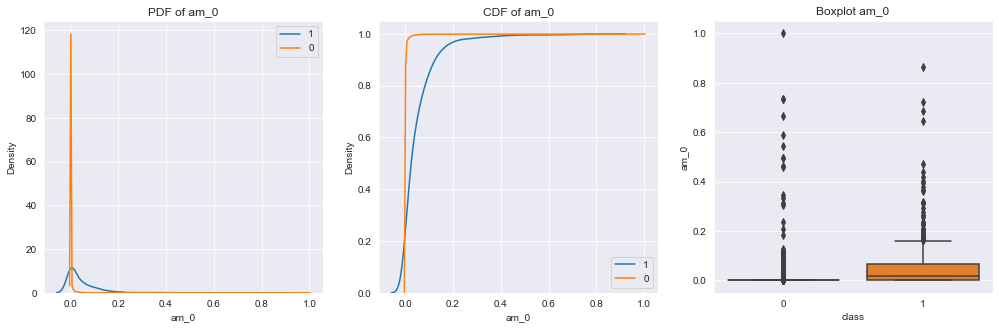

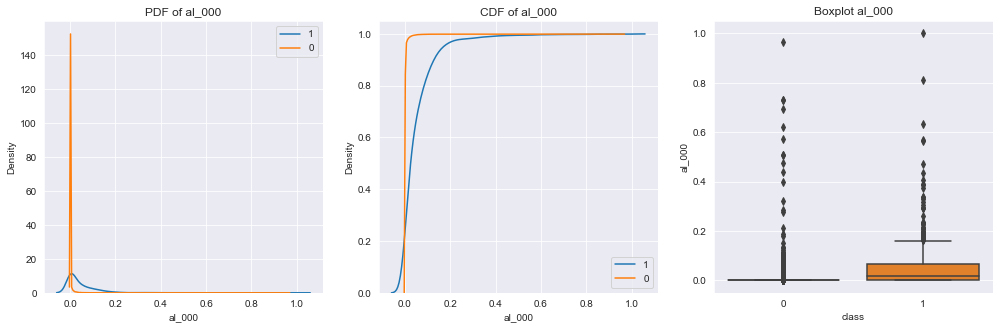

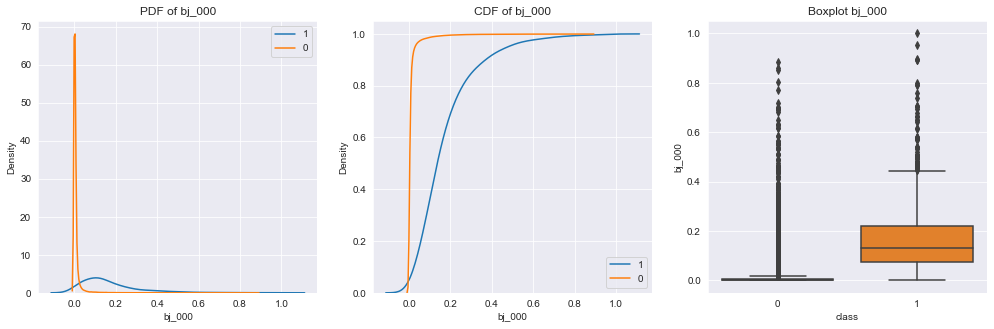

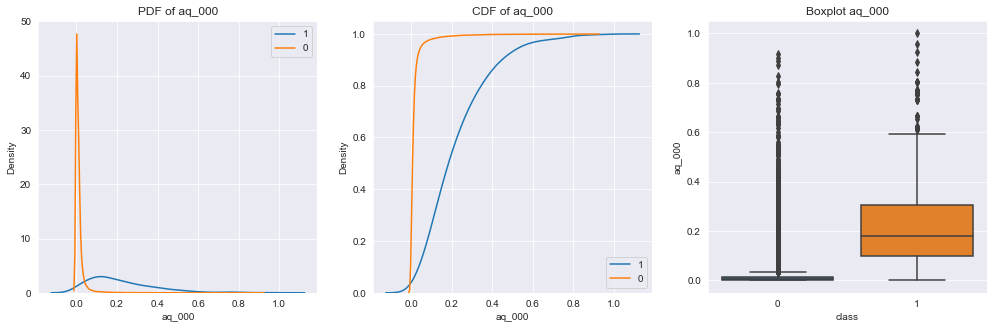

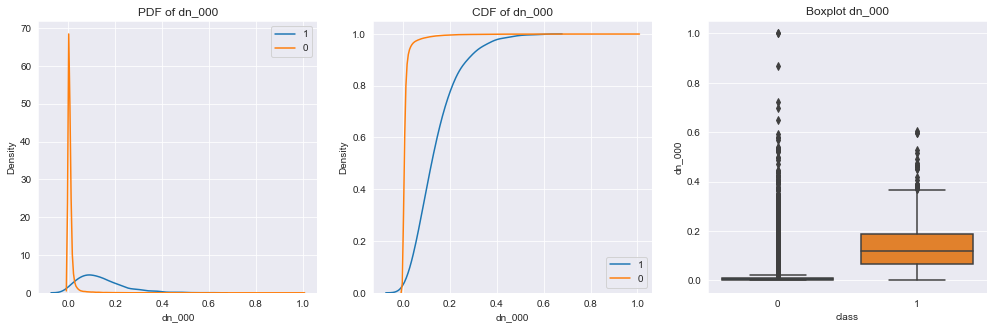

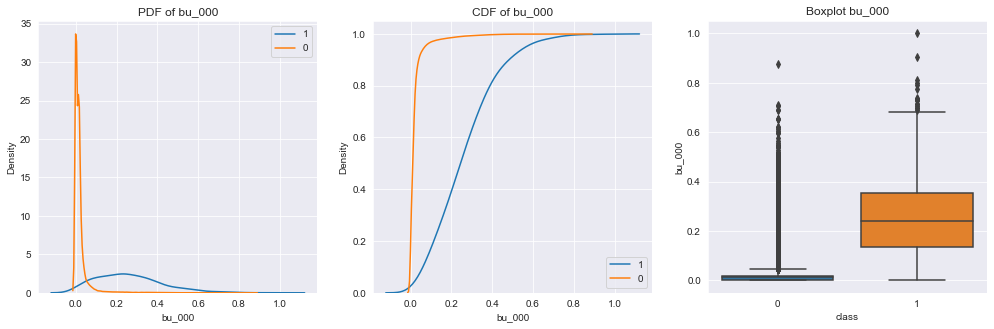

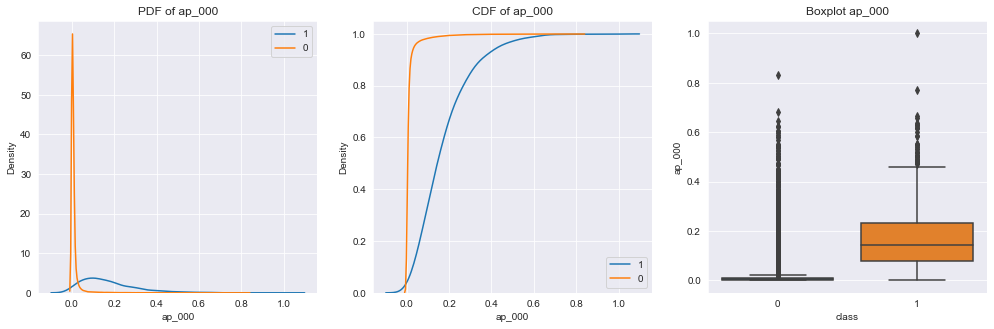

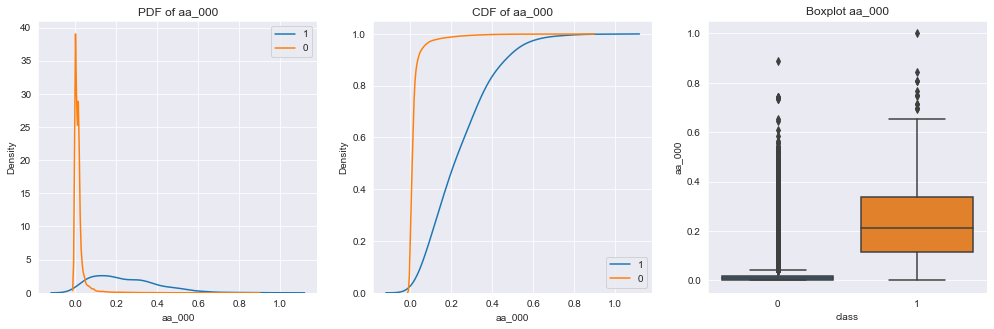

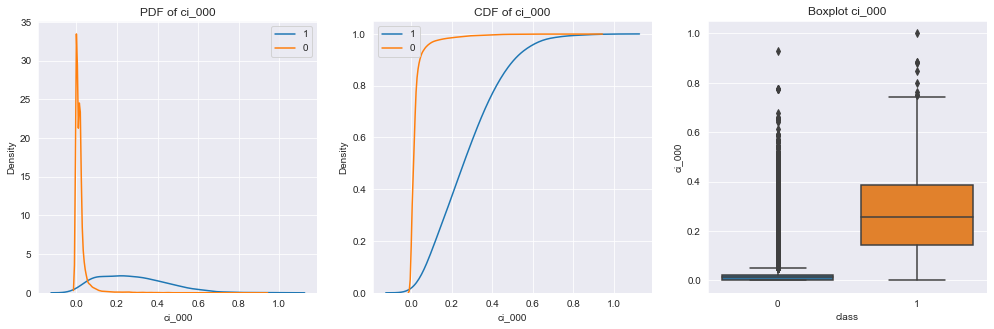

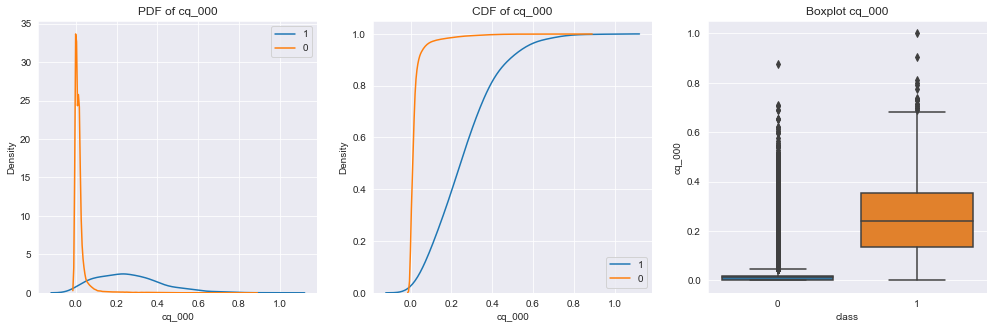

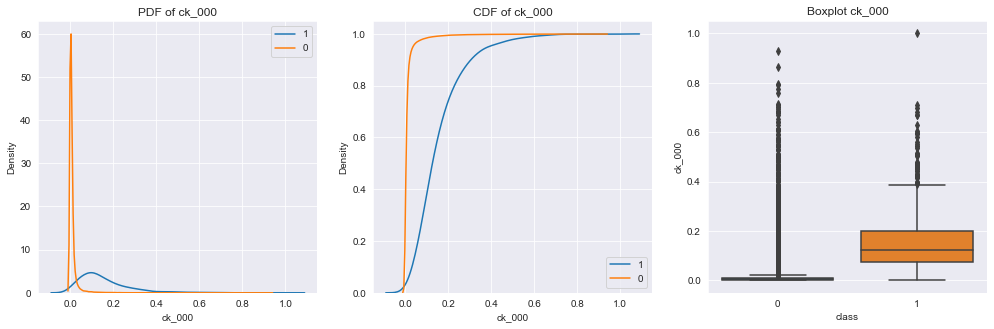

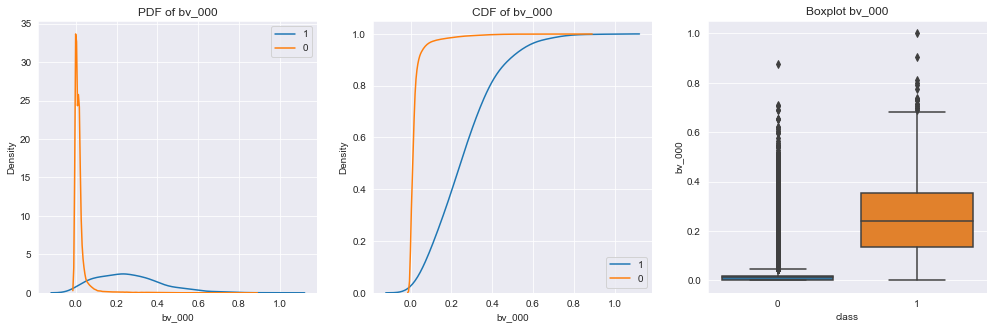

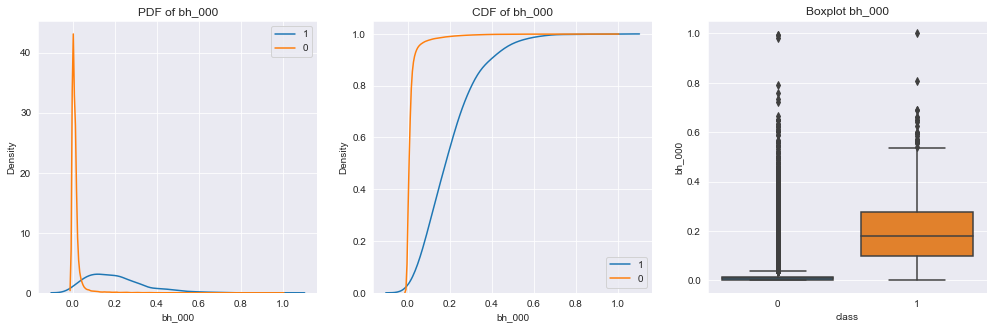

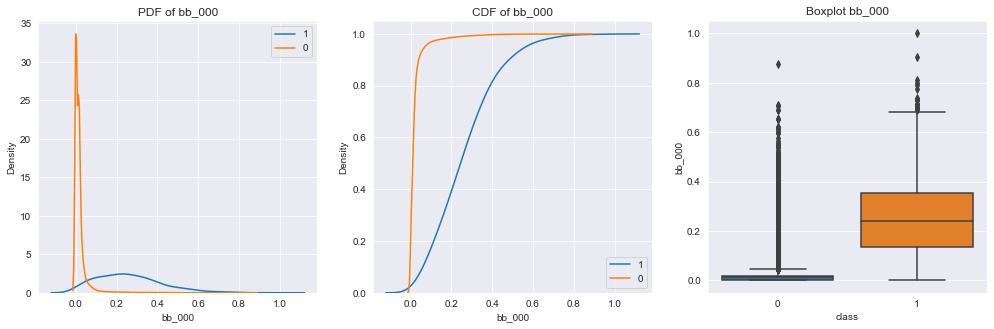

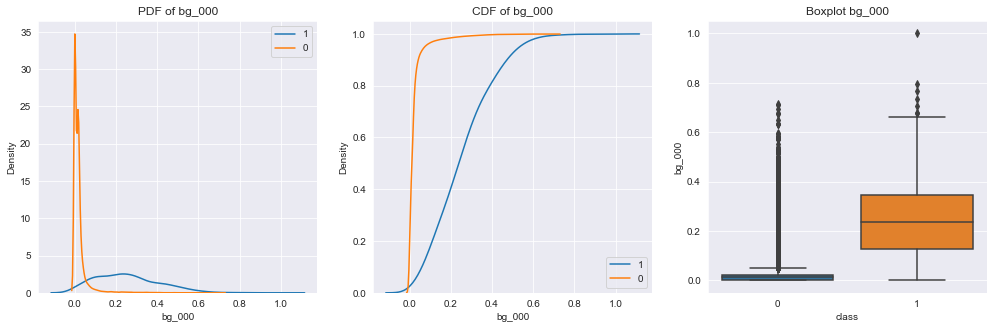

In [100]:
univariate_plots(X_num_top_15)

- From the box plots we can say that the features bj_000, ck_000, ci_000, aq_000, aa_000, bv_000, bb_000, ap_000, bu_000, bh_000, bg_000 and dn_000 have a good separation between the interquantile ranges of the positve and negative labeled points, which gives us a hint that these features could be useful in the classification.


- All the features except am_0, al_000 and do_000 have a significantly higher spread in the PDF and a not-so-steep increase in the CDF of positive labeled points, when compared to the negative labeled points.

<h2>Multivariate Analysis</h2>

##### Checking Correlation

Here also we will use the default correlation method of the pandas pairwise correlation API which is Pearson's correlation coefficient.

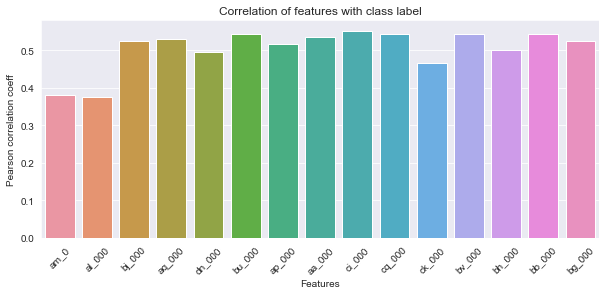

In [101]:
corr_with_Y(X_num_top_15)   

- Features am_0, al_000 and do_000 have a correlation of less than 0.40 with the class label.


- As several features have almost same correlation of close to 0.5 with the class labels, there is chance that these features might be correlated to each other. So now we will plot the correaltion matrix.

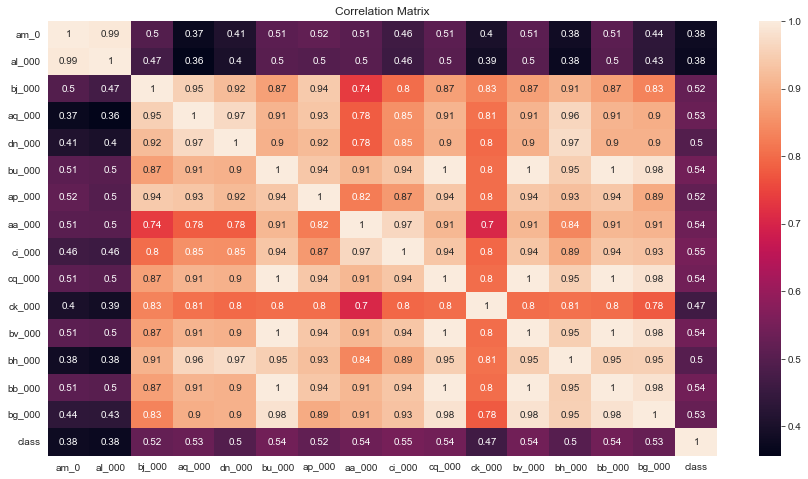

In [102]:
correlation_matrix(X_num_top_15)

- From the correlation matrix, we can see that majority of the features are having high correlation with each other (represented by the lighter coloured squares), except am_0 and al_000.


- Now we will select some featueres with low and high correaltion values and plot the scatter plots.

<h4>Scatter plots</h4>

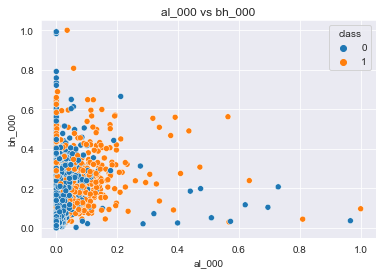

************************************************************


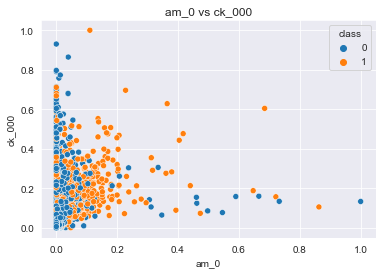

************************************************************


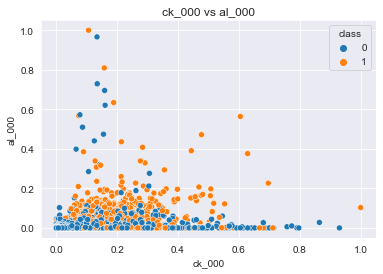

************************************************************


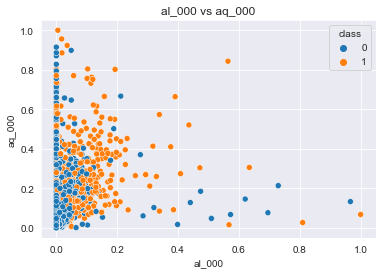

************************************************************


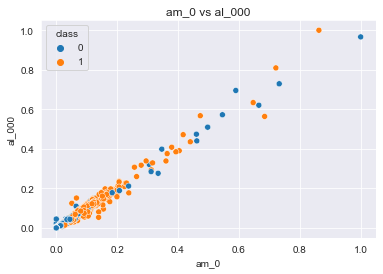

************************************************************


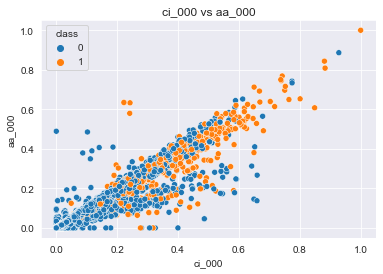

************************************************************


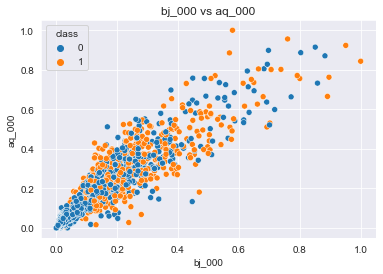

************************************************************


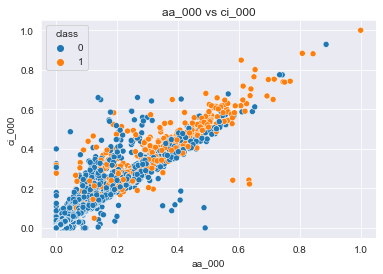

************************************************************


In [284]:
scatterplot('al_000','bh_000',X_num_top_15) 
scatterplot('am_0','ck_000',X_num_top_15) 
scatterplot('ck_000','al_000',X_num_top_15) 
scatterplot('al_000','aq_000',X_num_top_15) 

scatterplot('am_0','al_000',X_num_top_15) 
scatterplot('ci_000','aa_000',X_num_top_15) 
scatterplot('bj_000','aq_000',X_num_top_15) 
scatterplot('aa_000','ci_000',X_num_top_15) 

- The features for the first 4 plots were selected based on low correlation. Even though slight overlap between the positive and negative labeled points exists, majority of the positive labeled points are having more higher value than the negative labeled points and thus we can say that the features used in these 4 plots are somewhat useful.


- For the bottom 4 plots the datapoints are difficult to separate with the features am_0 vs al_000 plot showing an almost perfect positive correlation.


<h4>Pair Plots</h4>

We will select 7 features from the top 15 numerical features and plot the pair plot.

In [198]:
X_num_pp = X_num_top_15[['dn_000','al_000','cq_000','bh_000','bj_000','aa_000','bu_000','class']]

<Figure size 720x480 with 0 Axes>

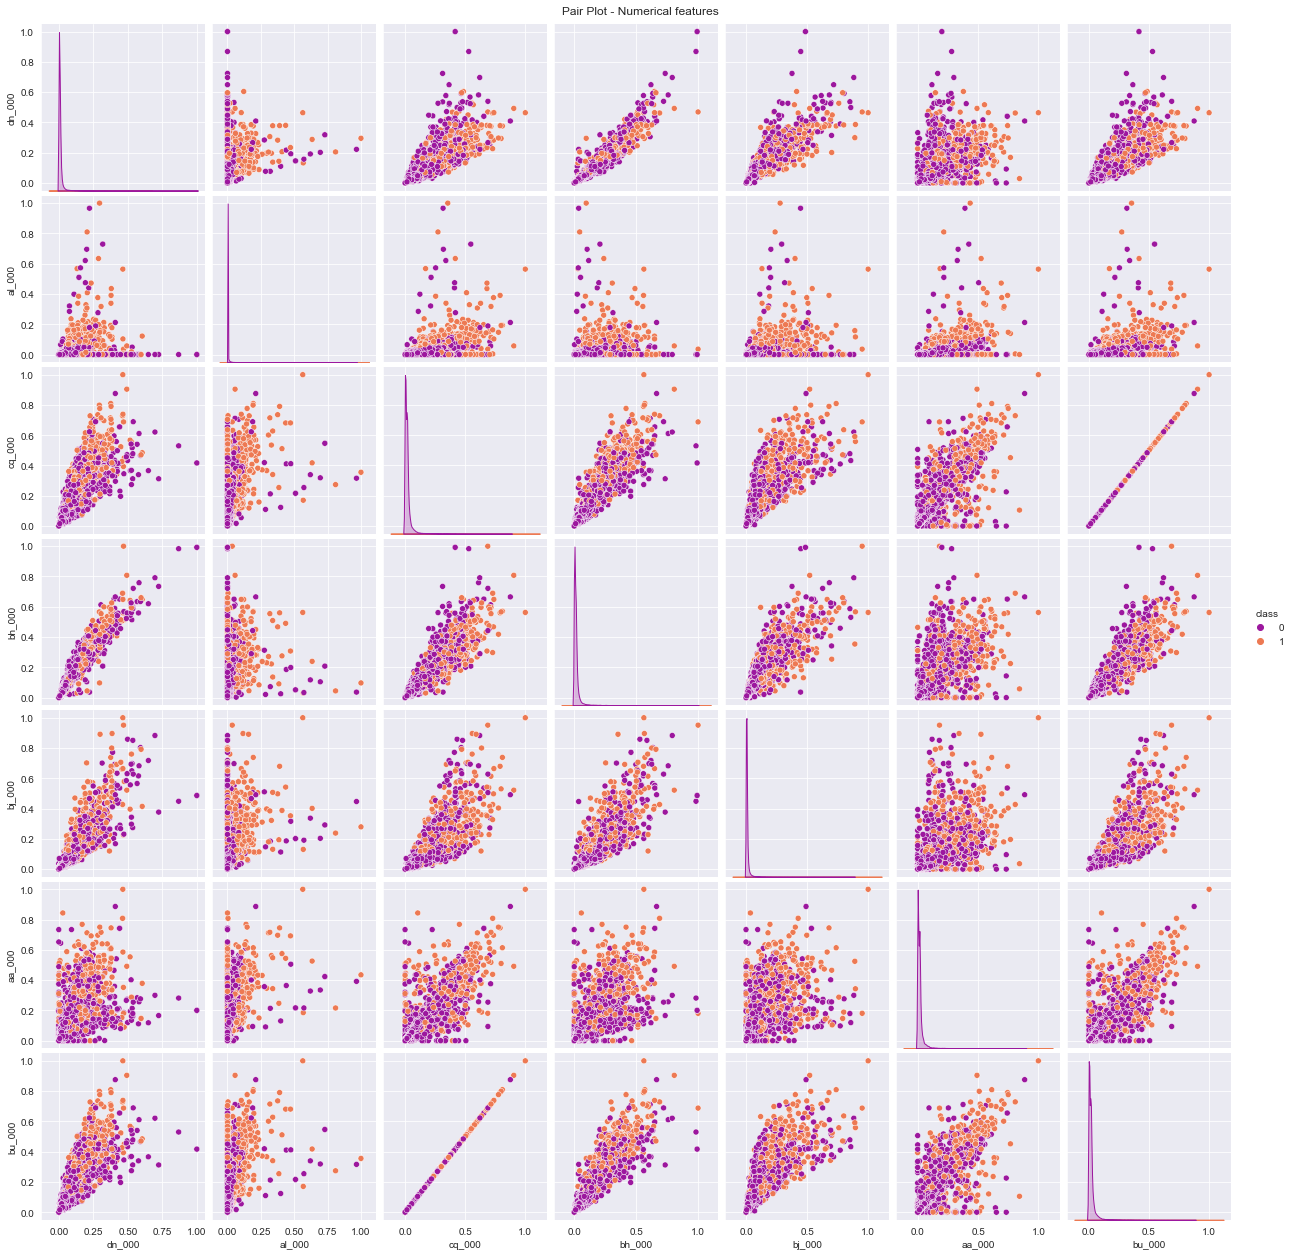

In [207]:
plt.figure(dpi = 120)
g=sns.pairplot(X_num_pp,hue='class',palette = 'plasma')
g.fig.suptitle('Pair Plot - Numerical features',fontsize='large',y=1.00)
plt.show()

- Features cq_000 and bu_000 are perfectly correlated indicated by the straight line plot between them. Hence it is not possible to classify the points with these 2 features.


- Most of the features have significant overlap between the positive and negative labeled points except al_000.


- The plots between al_000 and rest of the features plotted against it, shows some separation between the positive and negative labeled points. The positive labeled points have comparitevely higher value than the negative labeled points.

<h4>Applying TSNE for Data visualization</h4>

- Here also, initially we will plot the TSNE plot for the entire numerical features  and obtain the 2 dimensional visualization of the distributoin of data.


- Then we will plot the TSNE plot for the top 15 numerical features.

In [ ]:
## TSNE plot for all numerical features

tsne = TSNE(n_components=2, perplexity=50, verbose=10, n_jobs=-1)
transformed_num = tsne.fit_transform(X_train_num)

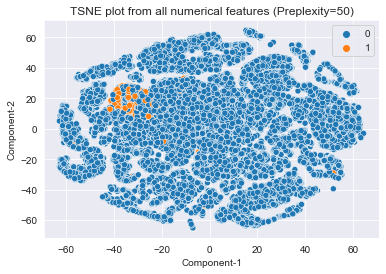

In [133]:
sns.scatterplot(transformed_num[:,0], transformed_num[:,1], hue=Y_train)
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('TSNE plot from all numerical features (Preplexity=50)')
plt.show()

From the above t-SNE plot where all the numerical features are considered, the positive labeld points can be seen as the orange  cluster inside the larger blue cluster of the negatively labeled points. 

Just like in the t-SNE plot for all the histogram features, here also due to the large number of negative labeled points, the presence of some positive labeled points are not identified.

In [ ]:
## TSNE plot for top 15 numerical features

tsne = TSNE(n_components=2, perplexity=50, verbose=10, n_jobs=-1)
transformed_15 = tsne.fit_transform(X_num_top_15)

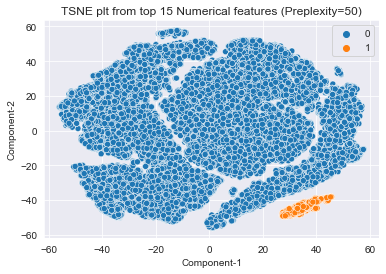

In [113]:
sns.scatterplot(transformed_15[:,0], transformed_15[:,1], hue=Y_train)
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('TSNE plt from top 15 Numerical features (Preplexity=50)')
plt.show()

Here also, just like from the TSNE plot of top 15 histogram features, we can see a clear cut separation between the positive and negative labeled points.

For the top 15 numerical features, the positive labeled orange cluster are even more well separated from the larger negative lableled blue cluster, than the top 15 histogram features. Hence the top 15 numerical features are really good in the classification.




<h3>Observations and conclusions from the univariate and multivariate analysis</h3>

- From the  plots used in EDA, we can clearly see that the data is highly imbalanced.


- Positive labeled points have comparatively higher values than negative labeled points. So in the context of our problem, this could mean that when feature is high then it is likely that the failure is an APS failure.


- Numerical features have higher correlation coefficient values with each other than the histogram features.


- But from the t-SNE plots it can be seen that numerical features can classify the datapoints better than the histogram features.


- As there are many high correlated features for numerical and histogram features, we can check the correlation of the whole dataset including both numerical and histogram features and remove the very highly correlated features.




#### Cheking Correlated features for the combined numeric and histogram datasets

In [103]:
## combining the numerical and histogram features ##

X_train_eda = pd.concat([X_train_hist, X_train_num], axis=1)
X_test_eda  = pd.concat([X_test_hist, X_test_num], axis=1)

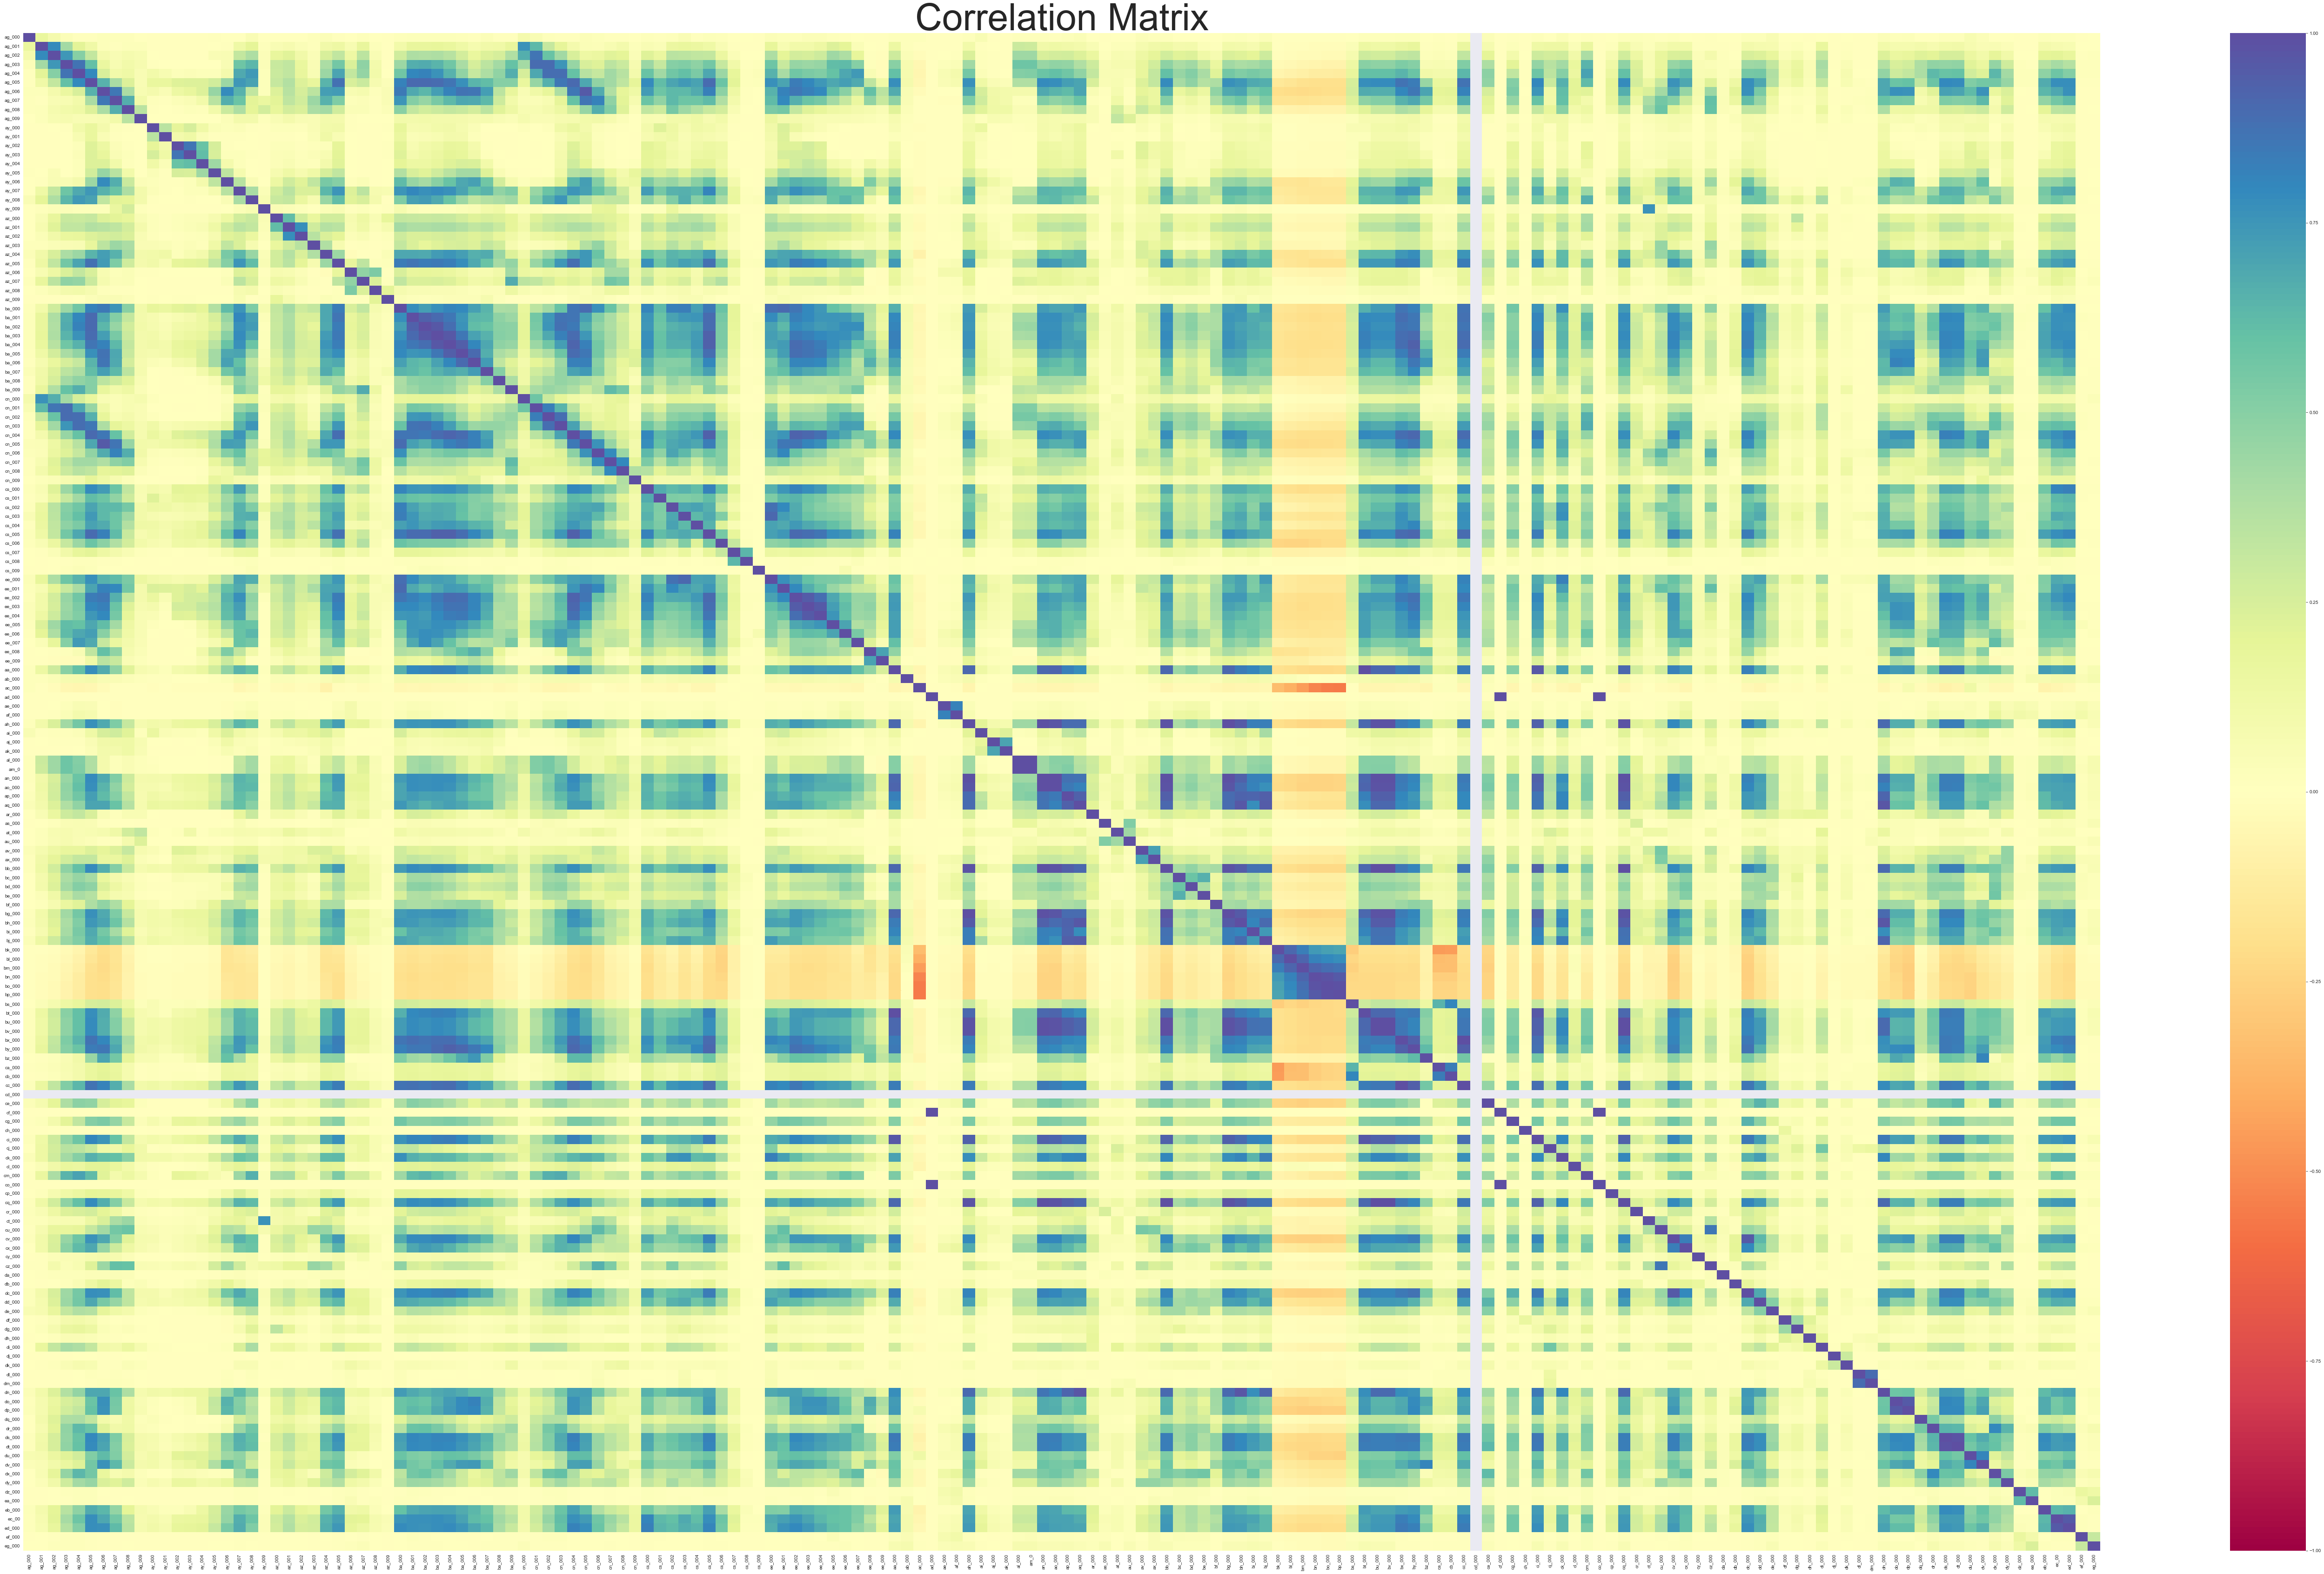

In [104]:
corr_matrix = X_train_eda.corr()
plt.figure(figsize=(100,60))
sns.heatmap(corr_matrix,cmap='Spectral',vmin=-1, vmax=1)
plt.title("Correlation Matrix",fontsize=80)
plt.show()

- From the correlation matrix of the entire features, we can see that most of the features have a low correlation represented by the majority of yellowish squares with a correlation in the range of 0 to 0.25


- The greenish squares represent an increased positive correlation and red square represents increased negative correlation.


- High correlated features contribute very less in predicting the output but increses the computational cost.


- So as there are a few number of high correlated features (dark blue squares), we will remove one of feature from each pair of these high correlated features. We will do this by considering only the upper traingle region of the correlation heatmap and check for the feature that shows a correlation of greater than 0.90 and later remove them from the train and test dataset.


<h4>Removing Highly correlated features</h4>

In [332]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

X_train_eda = X_train_eda.drop(X_train_eda[to_drop],axis=1)
X_test_eda  = X_test_eda.drop(X_test_eda[to_drop],axis=1)

print('Shape of X_train_eda after removing correlated features:',X_train_eda.shape)
print('Shape of X_test_eda after removing correlated features:',X_test_eda.shape)

Shape of X_train_eda after removing correlated features: (60000, 125)
Shape of X_test_eda after removing correlated features: (16000, 125)


# FEATURE ENGINEERING 

For feature engineering we will be considering 3 approaches:
- Checking if there is any relation between number of NaN values per datapoint and class label. If yes we will add the NaN value counts of each datapoint as a new feature.
- Local outlier factor - It measures the degree of outlyingness of an observation as a whole.
- Box plot Analysis - For each feature we will compare each value with a value obtained from the box plot of the same feature and we will check if the difference between these 2 would be of any use to us.

We will perform all these approaches to the dataset with numerical features. 


<h4> Checking if there is any relation between number of null values per datapoint and class label</h4>

In [334]:
null_count_train = X_train.isnull().sum(axis=1)
null_count_train = null_count_train.to_numpy()
df = pd.DataFrame({'class':Y_train,'null_count':null_count_train})
df.head(5)

class  null_count
0      0           5
1      0          21
2      0           8
3      0           8
4      0           7

Now we can plot the box plot of the null_count for the positive and negative class labeled points

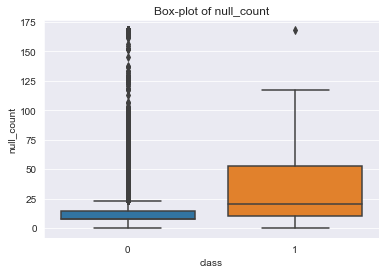

In [335]:
sns.boxplot(x='class',y='null_count',data=df)
plt.title('Box-plot of null_count')
plt.show()

- From the plot we can see that this feature might be useful in separating the class labels as there is reasonable separation between the boxplot for class 0 and 1. 


- The 50th percentile value of 'null_count' for class 1 is around 25, which is much higher than the 75th percentile value of 'null_count' for class 0. 


- Next, we will check the PDF of null_count for  class 1 and class 0. 

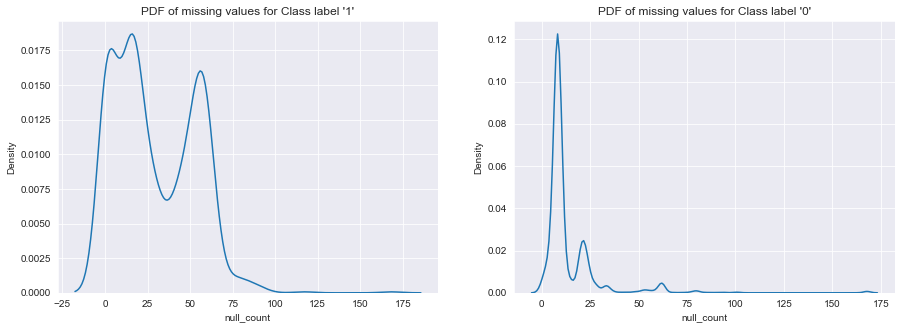

In [336]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.kdeplot(df[df['class']==1]['null_count'],ax=ax[0])
ax[0].set_title("PDF of missing values for Class label '1'")
sns.kdeplot(df[df['class']==0]['null_count'],ax=ax[1])
ax[1].set_title("PDF of missing values for Class label '0'")
plt.show()

- For class 0 we can see that majority of features have a null_count less than 20, while for class 1, the distrubution of null_count for the features is much more spread with several features having a null_count between ranges 0-25 and 50-75. 


- So we can add the null_count as a new feature to out dataset.

In [339]:
## adding null_count as a new features to train and test dataset

def null_count_feature(X1,X2):
    
    """   This function finds the number of null values present in each column fo the 
          dataset X1 and add this count as a new column to the dataset X2
    """
    
    null_count_train = X1.isnull().sum(axis=1)
    null_count_train = null_count_train.to_numpy()    
    X2['null_count'] = null_count_train

null_count_feature(X_train,X_train_eda)
null_count_feature(X_test,X_test_eda)


<h4>Local Outlier Factor</h4>

As discussed in one of the reference papers, we could create a new featuire using the local outlier factor as it identifies the outliers in the dataset. The local outlier factor(LOF) measures the degree of outlyingness of
an observation as a whole, and not just with respect to a single feature. It is a density based estimation is performed and the feature is compared with its local neighbourhood. If the density of an observation is low, then that might be an outlier.


In [344]:
def lof_features(data):
    
    '''   This function generates the local outlier factor for a given dataset 
          parameter:
          data - input dataset whose LOF is to be found out
    '''   
    lof = LocalOutlierFactor(n_neighbors=20)
    lof.fit(data)
    lof = lof.negative_outlier_factor_
    data['lof'] = lof

In [345]:
## adding LOF as a feature to train and test dataset

lof_features(X_train_eda)
lof_features(X_test_eda)

<h4>Box Plot Analysis</h4>

Another method to introduce new features to our dataset as discussed in one of reference paper is using Box plot. The way this can be done is as follows. For each feature we compare each value with a value obtained from the box plot of the same feature. If the difference in these values is comparitevely high, then that might be an outlier and this difference can be taken as a measure of outlyingness. 

So since a box plot gives the median and interquartile range, here we are taking the 25th and 75th percentile values of all the features for the comparison. So we will take the difference of all the values from the 25th and 75th percentiles values as the new features. So for each feature we will create 2 new features. 

So if we do this for the entire X_train_eda dataset we will reach close to 300 features which is a quite a lot. So we will first select the top 15 features from the X_train_num by using a random forest classifier, and then create the new features for the top 15 features only. 

In [346]:
forest  = RandomForestClassifier(n_estimators=50,random_state=42)
forest.fit(X_train_eda.drop(['null_count','lof'],axis=1), Y_train)
importance= forest.feature_importances_
indices = np.argsort(importance)[::-1]

In [ ]:
def quantiles_features(data):
    
    ''' 
        This function creates new features using the information from the box plot analysis. For each feature of the
        given dataset, it creates 2 new features which are the (i) difference between all elements of that feature and its 
        25th percentile and (ii) difference between all elements of that feature and its 75th percentile.        
        parameters:
        data - input data
    '''
    
    quantiles = {}
    for features in top_15['Features']:
         quantiles[features] = np.percentile(data[features],[25,75])
        
    for feature in top_15['Features']:
        feature_val = data[feature]
        new_feature_25 = feature_val - quantiles[feature][0]
        new_feature_75 = feature_val - quantiles[feature][1]
    
        data[feature+'_25'] = new_feature_25
        data[feature+'_75'] = new_feature_75

quantiles_features(X_train_eda)
quantiles_features(X_test_eda)

print('shape of train dataset after feature engineering:',X_train_eda.shape)
print('shape of test dataset after feature engineering:',X_test_eda.shape)

### Splitting the Dataset to Train and cross validation

In [244]:
X_train_eda = pd.read_csv('saves//X_train_eda_after_fe.csv',index_col=0)
X_test_eda = pd.read_csv('saves//X_test_eda_after_fe.csv',index_col=0)

In [245]:
X_train_eda,X_cv_eda,Y_train_eda,Y_cv_eda = train_test_split(X_train_eda,Y_train,test_size=0.20,stratify=Y_train)

In [250]:
print('shape of train dataset:',X_train_eda.shape)
print('shape of C.V dataset:',X_cv_eda.shape)

shape of train dataset: (48000, 157)
shape of C.V dataset: (12000, 157)


# Handling Class Imbalance

As the ratio of positive labeled points to the negative labeled points is 1000/59000 = 1:59, we need to address this imbalance in target variable. For that we are performing the ADASYN (Adaptive Synthetic )algorithm, which is an improved version of the state of the art SMOTE (Synthetic Minority Oversampling Technique) algorithm. ADASYN generates synthetic datapoints for minority class by giving more weightage to the harder to classify minority points.

We will perform the ADASYN algorithm using the imblearn module



In [254]:
from imblearn.over_sampling import ADASYN

oversampling = ADASYN()
X_train_oversampled, Y_train_oversampled = oversampling.fit_resample(X_train_eda, Y_train_eda)

In [255]:
X_train_oversampled

ag_000    ag_001    ag_002    ag_003        ag_004    ag_005    ag_006  \
0         0.0  0.000000  0.000000  0.000000  5.331455e-07  0.000039  0.001100   
1         0.0  0.000000  0.000000  0.000000  1.442115e-05  0.000040  0.000076   
2         0.0  0.000000  0.000000  0.000003  5.426722e-05  0.000020  0.000071   
3         0.0  0.000000  0.000000  0.000000  1.223613e-07  0.000099  0.000284   
4         0.0  0.000000  0.000000  0.000000  5.855861e-07  0.000002  0.000308   
...       ...       ...       ...       ...           ...       ...       ...   
94395     0.0  0.000000  0.000000  0.001593  1.344350e-02  0.035409  0.034097   
94396     0.0  0.000000  0.000000  0.003760  1.267054e-02  0.026747  0.021483   
94397     0.0  0.000517  0.012503  0.027290  2.915408e-02  0.041740  0.031610   
94398     0.0  0.000000  0.000000  0.003100  2.074563e-02  0.070306  0.090399   
94399     0.0  0.000501  0.012107  0.026436  2.867013e-02  0.041696  0.031917   

         ag_007    ag_008    ag_009  ...  ba_000_25  ba_000_75  ds_000_25  \
0      0.001024  0.000024  0.000000  ...   0.000189  -0.005149   0.000283   
1      0.000000  0.000000  0.000000  ...  -0.000075  -0.005412  -0.000142   
2      0.000000  0.000000  0.000000  ...  -0.000078  -0.005415  -0.000098   
3      0.000002  0.000000  0.000000  ...  -0.000063  -0.005400  -0.000084   
4      0.000450  0.000000  0.000000  ...  -0.000016  -0.005353  -0.000026   
...         ...       ...       ...  ...        ...        ...        ...   
94395  0.026536  0.043140  0.006724  ...   0.016886   0.011548   0.290326   
94396  0.015829  0.022470  0.003253  ...   0.013744   0.008407   0.205507   
94397  0.015954  0.021888  0.002908  ...   0.024575   0.019238   0.232205   
94398  0.024296  0.025708  0.003948  ...   0.048659   0.043322   0.247341   
94399  0.016484  0.022936  0.003092  ...   0.024389   0.019051   0.235587   

       ds_000_75  do_000_25  do_000_75  ag_005_25  ag_005_75  ay_005_25  \
0      -0.020649   0.000147  -0.020868  -0.000037  -0.005085   0.000000   
1      -0.021073  -0.000016  -0.021031  -0.000036  -0.005084   0.000000   
2      -0.021030  -0.000016  -0.021031  -0.000055  -0.005103   0.000000   
3      -0.021015  -0.000005  -0.021021   0.000024  -0.005024   0.000000   
4      -0.020958   0.000126  -0.020889  -0.000074  -0.005122   0.000000   
...          ...        ...        ...        ...        ...        ...   
94395   0.269395   0.166304   0.145289   0.035334   0.030286   0.000000   
94396   0.184575   0.101077   0.080062   0.026672   0.021624   0.000000   
94397   0.211273   0.116622   0.095607   0.041664   0.036616   0.000000   
94398   0.226409   0.110040   0.089024   0.070231   0.065183   0.002215   
94399   0.214655   0.119381   0.098366   0.041620   0.036573   0.000000   

       ay_005_75  
0      -0.000320  
1      -0.000320  
2      -0.000320  
3      -0.000320  
4      -0.000320  
...          ...  
94395  -0.000320  
94396  -0.000320  
94397  -0.000320  
94398   0.001894  
94399  -0.000320  

[94400 rows x 157 columns]

In [256]:
print('Number of positive labeled points after oversampling:',np.unique(Y_train_oversampled,return_counts=True)[1][1])
print('Number of negative labeled points after oversampling:',np.unique(Y_train_oversampled,return_counts=True)[1][0])

Number of positive labeled points after oversampling: 47200
Number of negative labeled points after oversampling: 47200


In [257]:
X_train_oversampled.to_csv('saves_2//X_train_oversampled.csv')

Y_train_oversampled_df = pd.DataFrame(Y_train_oversampled,columns=['Y_train_oversampled'])
Y_train_oversampled_df.to_csv('saves_2//Y_train_oversampled.csv')

- After performing the ADASYN algorithm the total number of train datapoints is increase from 48000 to 94000 with 47200 points belonging to positive class and 47200 points belonging to negative class. Each datapoint has 157 features.


- When we perform the modelling in the next stage, we can perform the technique of ADASYNBagging as described in one of the reference papers, where we need to perform ADASYN to each of the base learners of the baggging algorithm. Another ensemble learning technique that was mentioned in the reference paper is RSYNBagging where ADASYN and random undersampling is performed to the alternate base learners before performing the Bagging algoritm.


 As our problem is to reduce the operational cost of the company by reducing the misclassifcation of an actual APS fault as fault of some other components and vice versa, the ideal performance metric for our problem would be F1 score as it gives a score by balancing the value of precision and recall. Precision is the number of correctly predicted positive points (which is the true positives) out of the total predicted positive points (which is the sum of true and false positives). While recall is the number of correctly predicted positive points (which is the true positives) out of the total actual positive points (which is the sum of true positives and false negatives). 
 
 So from the equation of precision and recall the factor that distinguish them is the false positive for precision and false negative for recall. 
But for our problem statement we need to minimise the value of the cost function which gives more importance in reducing the false negtives than reducing the false positives, So we can use a more general F1 score that uses a positive real factor β (where β is chosen) such that recall is considered β times as important as precision. It is represented as,

<img src='f1_score.png'>

By a rule of thumb the common beta value, which weighs recall higher than precision is beta=2.

# Machine Learning Models

In [258]:
from sklearn.metrics import confusion_matrix,fbeta_score,roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import SGDClassifier
import random
from sklearn.metrics import fbeta_score, make_scorer

In [259]:

## F-Beta Score
def F_Beta_score(test_y, predict_y):
    FBScore = fbeta_score(test_y, predict_y,beta=2)
    return FBScore

## Total_cost
def Cost(test_y, predict_y):
    matrix = confusion_matrix(test_y, predict_y)
    FP = matrix[0][1]
    FN = matrix[1][0]
    cost = FP*10 + FN*500
    return cost

# Function to plot confusion matrix in heatmaps
def matrix_heatmaps(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points :",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1);
    sns.heatmap(C, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);
    # labels, title and ticks
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix');
   
    plt.subplot(1,3,2)
    sns.heatmap(B, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Precision Matrix');

    ax = plt.subplot(1,3,3)
    sns.heatmap(A, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Recall Matrix');  

### Baseline Model

We will first build a baseline model by just predicting the class labels for the test (cv) datapoints.
The prediction will be done as follows. For each datapoint a number between 0 and 1 is randomly selected and if it is greater than or equal to 0.5, we classify that point as positive class (1) and if it is less than 0.5 we classify it as negative class (0).

In [260]:
def baseline_model():
    
    y_pred = np.zeros(X_cv_eda.shape[0])  
    y_pred_proba = np.zeros(X_cv_eda.shape[0]) 
    for i in range(X_cv_eda.shape[0]):        
        sel = random.uniform(0,1)                   # select a random number between 0 and 1
        
        if sel >= 0.5:
            y_pred[i] = 1
            y_pred_proba[i] = sel
        else:
            y_pred[i] = 0
            y_pred_proba[i] = sel
    return y_pred,y_pred_proba

y_pred_bs,y_pred_proba_bs = baseline_model()


AUC score obtained by Baseline Model:  0.5338491525423729
F-Beta score obtained by Baseline Model:  0.0841874084919473
Total_cost:  101650
Percentage of misclassified points : 50.0


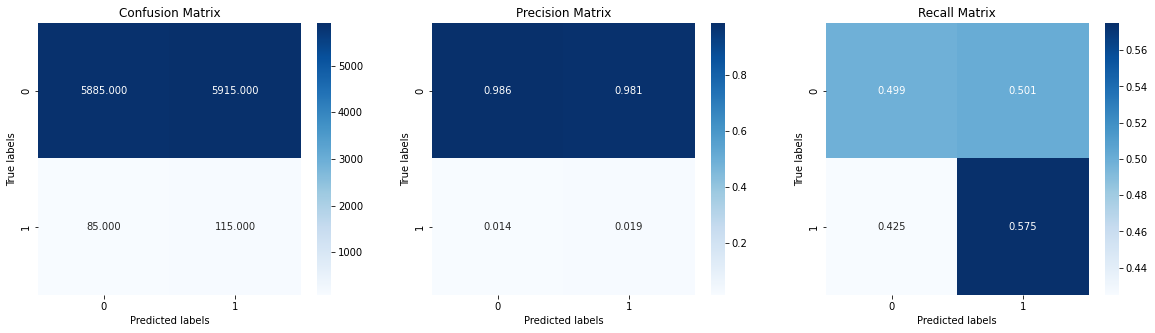

In [261]:
auc_score_bs = roc_auc_score(Y_cv_eda, y_pred_proba_bs[:])
print('AUC score obtained by Baseline Model: ',auc_score_bs)
Fbeta_cv_bs = F_Beta_score(Y_cv_eda,y_pred_bs)
print('F-Beta score obtained by Baseline Model: ',Fbeta_cv_bs)
cost_bs = Cost(Y_cv_eda,y_pred_bs)
print('Total_cost: ',cost_bs)
matrix_heatmaps(Y_cv_eda,y_pred_bs)

### Logistic Regression 

In [312]:
param = {'C' : [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]}

FBeta_score = make_scorer(fbeta_score,beta=2)

def false_negative(y_true, y_pred):
    c = confusion_matrix(y_true, y_pred)
    return c[1][0]

clf = LogisticRegression(penalty='l2',class_weight='balanced')
clf_tuning = RandomizedSearchCV(estimator=clf, param_distributions=param, 
                                scoring=make_scorer(false_negative,greater_is_better=False), cv=3, n_jobs=-1)

clf_tuning.fit(X_train_oversampled,Y_train_oversampled)

print('best C :',clf_tuning.best_params_['C'])

best C : 1


In [ ]:
clf = LogisticRegression(penalty='l2',C=1,class_weight='balanced')
clf.fit(X_train_oversampled,Y_train_oversampled)


In [314]:
pred_prob_train = clf.predict_proba(X_train_oversampled)
pred_prob_cv = clf.predict_proba(X_cv_eda)

auc_score_train_lr = roc_auc_score(Y_train_oversampled, pred_prob_train[:,1])
auc_score_cv_lr = roc_auc_score(Y_cv_eda, pred_prob_cv[:,1])

print('AUC score for oversampled train dataset: ',auc_score_train_lr)
print('AUC score for C.V dataset              : ',auc_score_cv_lr)

AUC score for oversampled train dataset:  0.9766061624712727
AUC score for C.V dataset              :  0.9877334745762711


In [315]:
y_pred_train_1 = clf.predict(X_train_oversampled)
y_pred_cv_1 = clf.predict(X_cv_eda)

Fbeta_train_lr = F_Beta_score(Y_train_oversampled,y_pred_train_1)
Fbeta_cv_lr    = F_Beta_score(Y_cv_eda,y_pred_cv_1)

print('F-Beta score for Train set: ',Fbeta_train_lr)
print('F-Beta score for CV set   : ',Fbeta_cv_lr)

F-Beta score for Train set:  0.9295227524972254
F-Beta score for CV set   :  0.6545209176788124


Total_cost on oversampled train dataset:  1844100
Total_cost on C.V dataset              :  7880
Percentage of misclassified points : 4.116666666666666


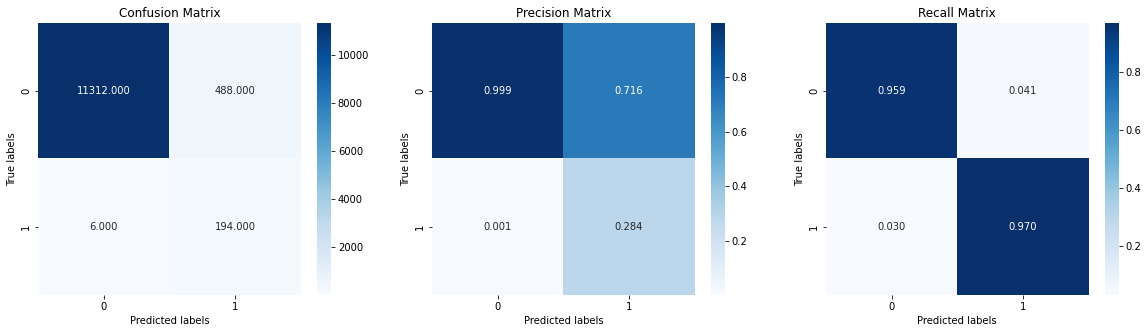

In [316]:
cost_train_lr = Cost(Y_train_oversampled,y_pred_train_1)
cost_cv_lr = Cost(Y_cv_eda,y_pred_cv_1)
print('Total_cost on oversampled train dataset: ',cost_train_lr)
print('Total_cost on C.V dataset              : ',cost_cv_lr)
matrix_heatmaps(Y_cv_eda,y_pred_cv_1)

In [317]:
pickle.dump(clf, open('models_2//log_regr.pkl', 'wb'))

# load the model from disk
#clf = pickle.load(open('models//log_regr.pkl', 'rb'))
#result = clf.predict(X_cv_oversampled) 

### Linear-SVM

In [282]:
param = {'alpha' : [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]}

clf_2 =  SGDClassifier(loss='hinge',class_weight = 'balanced', n_jobs=-1, random_state = 42)
clf_2_tuning = RandomizedSearchCV(estimator=clf_2, param_distributions=param,
                                  scoring=make_scorer(false_negative,greater_is_better=False), cv=3, n_jobs=-1)

clf_2_tuning.fit(X_train_oversampled,Y_train_oversampled)

print('best alpha :',clf_2_tuning.best_params_['alpha'])

best alpha : 0.001


In [283]:
clf_2 =  SGDClassifier(loss='hinge', alpha=0.001, class_weight = 'balanced', n_jobs=-1, random_state = 42)
clf_2.fit(X_train_oversampled,Y_train_oversampled)

SGDClassifier(alpha=0.001, class_weight='balanced', n_jobs=-1, random_state=42)

In [284]:
y_pred_train_2 = clf_2.predict(X_train_oversampled)
y_pred_cv_2 = clf_2.predict(X_cv_eda)

Fbeta_train_svm = F_Beta_score(Y_train_oversampled,y_pred_train_2)
Fbeta_cv_svm    = F_Beta_score(Y_cv_eda,y_pred_cv_2)

print('F-Beta score for oversampled train dataset: ',Fbeta_train_svm)
print('F-Beta score for C.V dataset              : ',Fbeta_cv_svm)

F-Beta score for oversampled train dataset:  0.8793987254087005
F-Beta score for C.V dataset              :  0.6443484521238301


Total_cost for oversampled train dataset:  3303520
Total_cost for C.V dataset              :  14600
Percentage of misclassified points : 3.591666666666667


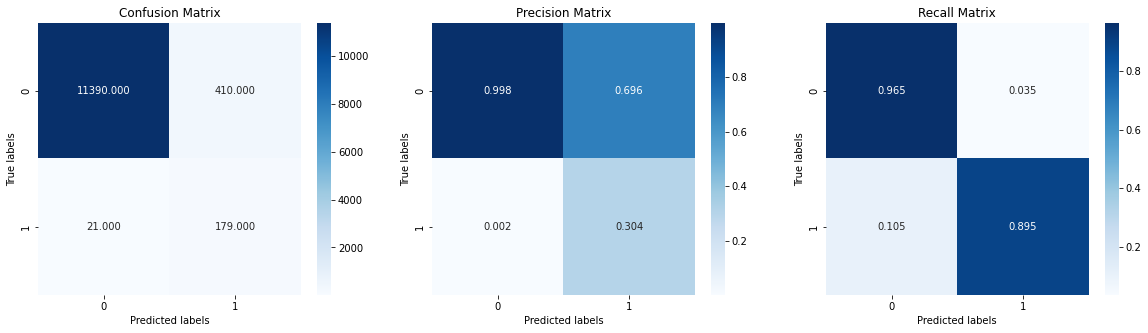

In [285]:
cost_train_svm = Cost(Y_train_oversampled,y_pred_train_2)
cost_cv_svm = Cost(Y_cv_eda,y_pred_cv_2)
print('Total_cost for oversampled train dataset: ',cost_train_svm)
print('Total_cost for C.V dataset              : ',cost_cv_svm)

matrix_heatmaps(Y_cv_eda,y_pred_cv_2)

In [286]:
pickle.dump(clf_2, open('models_2//lin_svm.pkl', 'wb'))

### Random Forest

In [287]:
clf_3 = RandomForestClassifier()
param_grid = { 
    'n_estimators': [10,50,100,200],
    'max_depth' : [10,50,80],
    'min_samples_leaf': [3, 4, 5],
    'criterion' :['gini', 'entropy']
}

clf_3_tuning = RandomizedSearchCV(estimator=clf_3, scoring=make_scorer(false_negative,greater_is_better=False), param_distributions=param_grid,n_jobs=-1, cv= 3)
clf_3_tuning.fit(X_train_oversampled, Y_train_oversampled)
print('best_params: ',clf_3_tuning.best_params_)

best_params:  {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}


In [ ]:
clf_3 = RandomForestClassifier(n_estimators= 100,min_samples_leaf= 4,max_depth= 10,criterion= 'entropy',
                               n_jobs=-1,class_weight='balanced')
clf_3.fit(X_train_oversampled, Y_train_oversampled)

In [289]:
pred_prob_train = clf_3.predict_proba(X_train_oversampled)
pred_prob_cv = clf_3.predict_proba(X_cv_eda)

auc_score_train_rf = roc_auc_score(Y_train_oversampled, pred_prob_train[:,1])
auc_score_cv_rf = roc_auc_score(Y_cv_eda, pred_prob_cv[:,1])

print('AUC score for oversampled train set: ',auc_score_train_rf)
print('AUC score for C.V set              : ',auc_score_cv_rf)

AUC score for oversampled train set:  0.9998485990914967
AUC score for C.V set              :  0.993635593220339


In [290]:
y_pred_train_3 = clf_3.predict(X_train_oversampled)
y_pred_cv_3 = clf_3.predict(X_cv_eda)

Fbeta_train_rf = F_Beta_score(Y_train_oversampled,y_pred_train_3)
Fbeta_cv_rf    = F_Beta_score(Y_cv_eda,y_pred_cv_3)

print('F-Beta score for Train set: ',Fbeta_train_rf)
print('F-Beta score for CV set: ',Fbeta_cv_rf)

F-Beta score for Train set:  0.9959961441218999
F-Beta score for CV set:  0.776778413736713


Total_cost for oversampled train dataset:  48570
Total_cost for C.V dataset              :  7330
Percentage of misclassified points : 2.025


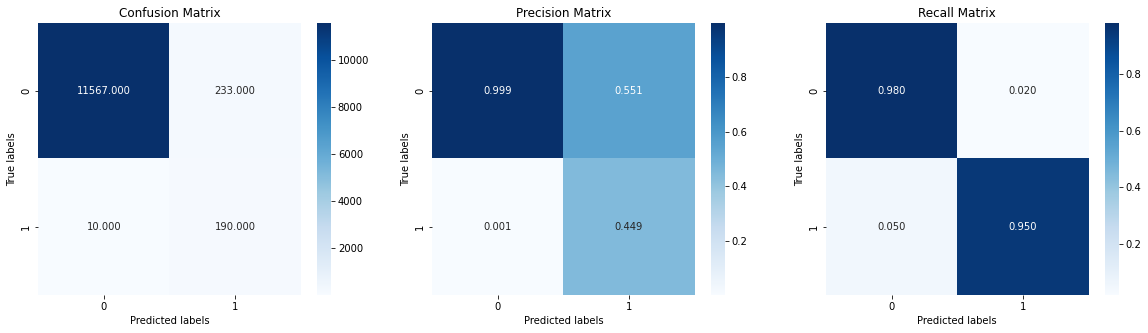

In [291]:
cost_train_rf = Cost(Y_train_oversampled,y_pred_train_3)
cost_cv_rf = Cost(Y_cv_eda,y_pred_cv_3)
print('Total_cost for oversampled train dataset: ',cost_train_rf)
print('Total_cost for C.V dataset              : ',cost_cv_rf)
matrix_heatmaps(Y_cv_eda,y_pred_cv_3)

In [292]:
pickle.dump(clf_3, open('models_2//rf.pkl', 'wb'))

### XGBoost

In [ ]:
clf_4=xgb.XGBClassifier()
param_grid={
    'learning_rate':[0.001,0.01,0.05,0.1],
     'n_estimators':[50,100,200],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.5,1],
    'subsample':[0.1,0.5,1]
}
clf_4_tuning = RandomizedSearchCV(estimator=clf_4, scoring=make_scorer(false_negative,greater_is_better=False), param_distributions=param_grid,n_jobs=-1, cv= 3)
clf_4_tuning.fit(X_train_oversampled, Y_train_oversampled)
print('best_parameters: ',clf_4_tuning.best_params_)

In [306]:
clf_4 = xgb.XGBClassifier(subsample= 1,n_estimators= 100,max_depth =5,learning_rate= 0.1,colsample_bytree= 0.5)
clf_4.fit(X_train_oversampled, Y_train_oversampled)

[21:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [307]:
pred_prob_train = clf_4.predict_proba(X_train_oversampled)
pred_prob_cv = clf_4.predict_proba(X_cv_eda)

auc_score_train_xgb = roc_auc_score(Y_train_oversampled, pred_prob_train[:,1])
auc_score_cv_xgb = roc_auc_score(Y_cv_eda, pred_prob_cv[:,1])

print('AUC score for oversampled train set: ',auc_score_train_xgb)
print('AUC score for C.V set              : ',auc_score_cv_xgb)

AUC score for oversampled train set:  0.9999277762316863
AUC score for C.V set              :  0.9946470338983051


In [308]:
y_pred_train_4 = clf_4.predict(X_train_oversampled)
y_pred_cv_4 = clf_4.predict(X_cv_eda)

Fbeta_train_xgb = F_Beta_score(Y_train_oversampled,y_pred_train_4)
Fbeta_cv_xgb   = F_Beta_score(Y_cv_eda,y_pred_cv_4)

print('F-Beta score for oversampled train set: ',Fbeta_train_xgb)
print('F-Beta score for C.V set              : ',Fbeta_cv_xgb)

F-Beta score for oversampled train set:  0.9978749253895618
F-Beta score for C.V set              :  0.8386801099908341


Total_cost for oversampled train set:  30320
Total_cost for C.V set              :  9580
Percentage of misclassified points : 1.0416666666666665


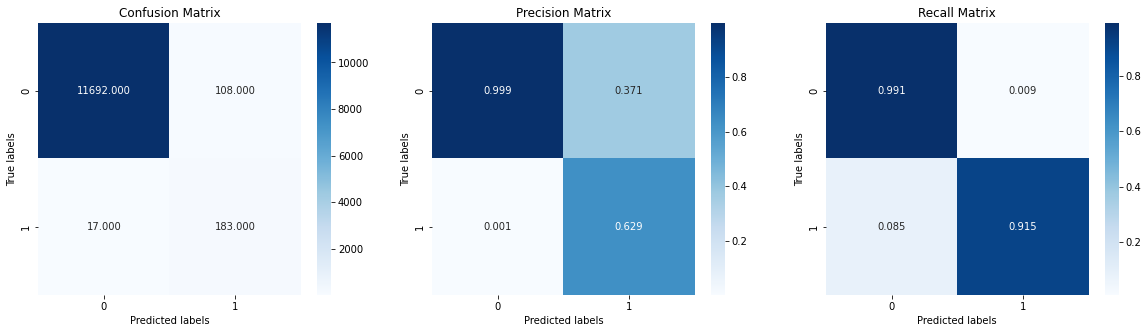

In [309]:
cost_train_xgb = Cost(Y_train_oversampled,y_pred_train_4)
cost_cv_xgb = Cost(Y_cv_eda,y_pred_cv_4)
print('Total_cost for oversampled train set: ',cost_train_xgb)
print('Total_cost for C.V set              : ',cost_cv_xgb)
matrix_heatmaps(Y_cv_eda,y_pred_cv_4)

In [310]:
pickle.dump(clf_4, open('models_2//xgb.pkl', 'wb'))

In [318]:
from prettytable import PrettyTable 
myTable = PrettyTable(['Model','Total_Cost','CV_F-Beta_score','CV_AUC_score'])
myTable.add_row(['Baseline Model',cost_bs,Fbeta_cv_bs,auc_score_bs])
myTable.add_row(['Logistic Regression',cost_cv_lr,Fbeta_cv_lr,auc_score_cv_lr])
myTable.add_row(['Linear-SVM',cost_cv_svm,Fbeta_cv_svm,'-'])
myTable.add_row(['Random Forest',cost_cv_rf,Fbeta_cv_rf,auc_score_cv_rf])
myTable.add_row(['XGBoost',cost_cv_xgb,Fbeta_cv_xgb,auc_score_cv_xgb])
print(myTable)

+---------------------+------------+--------------------+--------------------+
|        Model        | Total_Cost |  CV_F-Beta_score   |    CV_AUC_score    |
+---------------------+------------+--------------------+--------------------+
|    Baseline Model   |   101650   | 0.0841874084919473 | 0.5338491525423729 |
| Logistic Regression |    7880    | 0.6545209176788124 | 0.9877334745762711 |
|      Liner-SVM      |   14600    | 0.6443484521238301 |         -          |
|    Random Forest    |    7330    | 0.776778413736713  | 0.993635593220339  |
|       XGBoost       |    9580    | 0.8386801099908341 | 0.9946470338983051 |
+---------------------+------------+--------------------+--------------------+


-  All of our models showed significant increase in the performance when compared to the baseline model.


- The best cross validation AUC score obtained is 0.99464 for the XGBoost Model, which is greater than the highest AUC score of the Kaggle leaderboard for the Community prediction competition for the "Scania Truck Failures prediction" dataset. https://www.kaggle.com/c/scania-truck-failures/data


- The lowest cost was obtained for the Random Forest model.


- Next we shall try a custom Stacking classifier model and try to further reduce the total_maintanance cost of the trucks.

